# Blue Horizontal Branch Stars
## MSP, 23.5.2019

Cleaned Notebook to analyse Blue Horizontal Branch data

## Steps

1. Read in Xue 2008, 2011 catalog
2. Think about satellite disruption and dynamics



In [ ]:
# the master list of definitions

import reflexmotion as rm

In [118]:
# print to a file...

# with a flipped vb ONLY?


def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # following the astropy conversion
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    #dL=np.arctan(y0/x0)/f
    
    #dL[(y0<0)&(x0>0.)] += 360.
    #dL[(y0>0)&(x0<0.)] += 180.
    #dL[(y0<0)&(x0<0.)] += 180.
    
    dL = np.arctan2(y0,x0)/f
    
    #print(dL)
    
    if dL.size>1:
        dL[np.array(dL)<0.] += 360.
    else:
        if dL<0.: dL+=360.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub


#dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(KGiant.x),np.array(KGiant.y),np.array(KGiant.z),\
#                               np.array(KGiant.vx),np.array(KGiant.vy),np.array(KGiant.vz))













In [1]:
# standard python modules
import numpy as np;import time;import copy

# plotting utilities
import matplotlib.pyplot as plt;import matplotlib as mpl;import matplotlib.cm as cm;import matplotlib.colors as colors
%matplotlib inline

cmap = mpl.cm.inferno


import scipy.interpolate as interpolate;import subprocess;from astropy.io import fits

In [2]:
# exptool imports
from exptool.basis import eof;from exptool.basis import spheresl;from exptool.basis import *

from ssl import *;from exptool.io import psp_io

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

from exptool.utils import *

stylepar='medium'

if stylepar == 'medium':
    mpl.rcParams['font.weight'] = 'medium'
    mpl.rcParams['axes.linewidth'] = 1.5
    mpl.rcParams['xtick.major.width'] = 1.5
    mpl.rcParams['xtick.minor.width'] = 0.75
    mpl.rcParams['xtick.minor.visible'] = True
    mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['ytick.minor.width'] = 0.75
    mpl.rcParams['ytick.minor.visible'] = True







In [3]:
# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u

The Xue+ 2011 sample consists of ∼4000 objects drawn from SDSS DR8 (Eisenstein et al. 2011) that pass both the colour cuts of Yanny et al. (2000) and the two Balmer-line profile cuts already described in Xue et al. (2008), but here slightly relaxed (see Xue et al. 2011). We retrieve these objects in DR9 and adopt the latter values for both their physical parameters and their astrometry.



Following the methodology in Deason et al. (2018), we begin with the blue horizontal branch sample of Xue et al. (2011). Drawn from the spectroscopic sample of SEGUE stars, the BHBs are identified via a color cut and Balmer-line profile cuts, as described in Xue et al. (2011), with references to Yanny et al. (2000) and Xue et al. (2008).

In [5]:
# now use the the color and metallicity dependent 
# absolute magnitude relation derived by Fermani & Schönrich (2013)

def fs_mag(gr,feh):
    """use equation 5 of fermani & schonrich 2013 to get the absolute G magnitude
    """
    
    gvals = 0.0075 * np.exp(-14.*gr) + 0.04 * (feh + 3.5)**2. + 0.25
    
    gvals[feh<-5.] = np.nan

    return gvals
    
    
    

In [34]:
#RAJ2000;DEJ2000;GLON;GLAT;gmag;u-g;D0.2;fm;cHg;bHg;d;r;x;y;z;HRV;e_HRV;Vgal;DR8;Sloan;SimbadName


X11 = np.genfromtxt('data/Xue2011BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D02","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')


# hand-make the matching table
f = open('data/matchingbhb.txt','w')

print('name ra  dec',file=f)

for x in range(0,len(X11['RA'])):
    print('S'+str(x),X11['RA'][x],X11['Dec'][x],file=f)

f.close()

# match BHBs against the SDSS spectra
X11m = np.genfromtxt('data/Xue2011BHBxmatch.txt',\
                        dtype={'names': ("Name","specobjid","ra","dec",\
                                         "plate","mjd","fiberid","fehadop",\
                                        "fehadopunc","elodiervfinal","elodiervfinalerr",\
                                         "fehspec","fehspecunc","psfg","fibreg"),\
                             'formats': ('S20','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8',\
                                        'f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')




GmatchO = np.genfromtxt('data/Xue2011BHBxmatch_gaia.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

Gmatch = np.genfromtxt('data/Xue2011BHBxmatch_gaia_corr.txt',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"),\
                             'formats': ('S20','S20','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')

# there is a uniqueness problem that requires additional matching.

In [39]:
# hand-make the crossmatches


# need to double check all this matching...something doesn't seem right.
decoded_names = np.array([int((X11m['Name'][x].decode()).strip('S')) for x in range(0,X11m['Name'].size)])

# do the cross-matching to the original Xue sample
# everything is therefore matched to the X11 sample


# can take all the X11 data
grvals = X11["gr"]


gaiadict = {}

matchlist = ["gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","pmcorr","dist"]

for match in matchlist:
    gaiadict['g'+match] = np.zeros(grvals.size)
    

sdss_list = ["specobjid","ra","dec",\
                                         "plate","mjd","fiberid","fehadop",\
                                        "fehadopunc","elodiervfinal","elodiervfinalerr",\
                                         "fehspec","fehspecunc","psfg","fibreg"]

for match in sdss_list:
    gaiadict['s'+match] = np.zeros(grvals.size)
    


# this performs the matching. loop over each source...
for indx,val in enumerate(decoded_names):
    
    # add the sdss data, identified by decoded name
    for match in sdss_list:
        gaiadict['s'+match][val] = X11m[match][indx]
    
    # add the gaia data
    try:
        for match in matchlist:
            # identify by matching the name down the list.
            gaiadict['g'+match][val] = Gmatch[match][Gmatch['xsource_id']==X11m['Name'][indx]]
    except:
        print('Failure')
    




Failure
Failure
Failure
Failure
Failure
Failure


In [40]:
# set the magnitude limit
#keep = np.where(gaiag < 17.2)
#keep = np.where(psfg < 17.2)
#keep = np.where((X11['gmag'] < 17.0) & (X11['gr'] > -0.4) & (np.isnan(pmr)!=True)\
#                & (fehvals > -3.) & (np.isnan(radval)!=True) & (np.abs(raval-X11['RA'])<0.1))

#keep = np.where((X11['gmag'] < 19.0) & (X11['gr'] > -0.4) & (np.isnan(pmr)!=True)\
#                & (fehvals > -3.) & (np.isnan(radval)!=True) & (np.abs(raval-X11['RA'])<0.1))

# keep all!
keep = np.where(gaiadict['gphot_g_mean_mag'])

print(keep[0].size)




4944


(array([93]),)


Text(0.5, 1.0, 'RUWE for stars at $>$50 kpc')

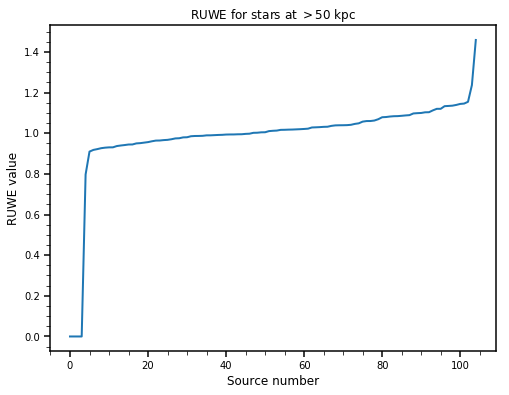

In [41]:
# append RUWE data

RU = np.genfromtxt('data/Xue2011BHB_xmatch_gaia_ruwe.txt',skip_header=1,delimiter=',')

gaiadict['gruwe'] = np.zeros(gaiadict['gpmdec_error'].size)

for i in range(0,gaiadict['gpmdec_error'].size):
    try:
        #print(RU[gaiadict['gpmdec_error'][i]==RU[:,0],0],gaiadict['gpmdec_error'][i])
        gaiadict['gruwe'][i] = RU[gaiadict['gpmdec_error'][i]==RU[:,0],23]
    except:
        pass
    #print(RU[i,23],gaiadict['gdec'][gaiadict['gpmdec_error']==RU[i,0]])
    

distsize = gaiadict['gruwe'][X11['d']>50]

print(np.where(distsize>1.4))

plt.plot(distsize[distsize.argsort()])

plt.xlabel('Source number',size=12)
plt.ylabel('RUWE value',size=12)
plt.title('RUWE for stars at $>$50 kpc',size=12)

Text(0.5, 1.0, 'Correlation for stars at $>$50 kpc')

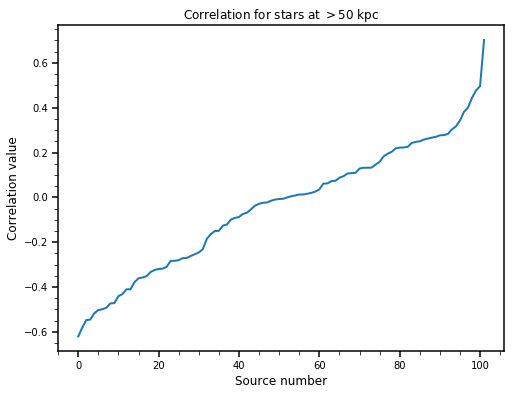

In [42]:
# check how strong the velocity correlations are
distsize = gaiadict['gpmcorr'][X11['d']>50]

plt.plot(distsize[distsize.argsort()])

plt.xlabel('Source number',size=12)
plt.ylabel('Correlation value',size=12)
plt.title('Correlation for stars at $>$50 kpc',size=12)

[]
[219]


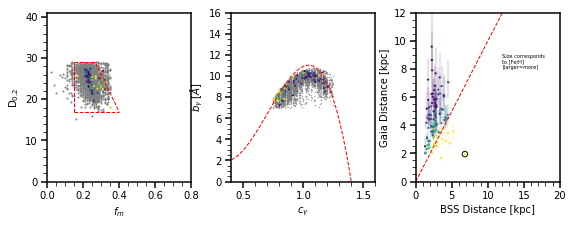

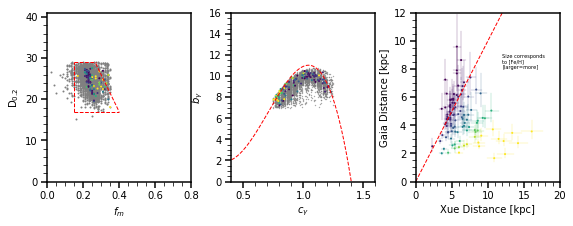

In [16]:
mval = gaiadict['sfehadop'][w]
mval[mval<-5.] = -2.5
print(mval)
#plt.plot(mval[mval.argsort()])


def bss_mag(gr):
    return 3.108 + 5.495*gr

Gmag = bss_mag(X11['gr'])

bssdist = 10.**((X11['gmag']-Gmag+5.)/5.-3.)




fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.1,0.17,0.25,0.78])
ax2 = fig.add_axes([0.42,0.17,0.25,0.78])
ax3 = fig.add_axes([0.74,0.17,0.25,0.78])

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

drat = X11['d']*gaiadict['gparallax']
w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5)[0]

mvalsize = 6.*(mval+2.5)

ax1.scatter(X11['fm'],X11["D02"],color='gray',s=1.)
ax1.scatter(X11['fm'][w],X11["D02"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def draw_d_fm_polygon(ax):
    """draw santucci BSS polygon
    
    default color and linestyles only...
    """
    color='red'
    linestyle='dashed'
    lw=1.
    ax.plot([0.15,0.27],[29.,29.],color=color,linestyle=linestyle,lw=lw)
    ax.plot(np.linspace(0.27,0.40,100),-90.*np.linspace(0.27,0.40,100)+53.,color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.4],[17.,17.],color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.15],[17.,29.],color=color,linestyle=linestyle,lw=lw)


draw_d_fm_polygon(ax1)


ax1.set_xlabel('$f_m$',size=10)
ax1.set_ylabel('D$_{0.2}~[\AA]$',size=10)
ax1.axis([0.,0.8,0.,41.])

ax2.scatter(X11['cHg'],X11["bHg"],color='gray',s=0.1)
ax2.scatter(X11['cHg'][w],X11["bHg"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def b_c_relation(c):
    """santucci 2014 cutoff for BHB and BS stars"""
    return 9.20 - 46.32*c + 82.24*c*c - 23.36*c*c*c - 10.82*c*c*c*c

crange = np.linspace(0.4,1.6,1000)
ax2.plot(crange,b_c_relation(crange),color='red',linestyle='dashed',lw=1.)

ax2.set_xlabel('$c_\gamma$',size=10)
ax2.set_ylabel('$b_\gamma$ $[\AA]$',size=10)
ax2.axis([0.4,1.6,0,16])

#w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
#ax3.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=mvalsize,color=cm.viridis((drat[w]-0.8)/2.,1.))
ax3.scatter(bssdist[w],1./gaiadict['gparallax'][w],s=mvalsize,color=cm.viridis((drat[w]-0.8)/2.,1.))


for i in w:
    ax3.plot([bssdist[i],bssdist[i]],\
             [1./(gaiadict['gparallax'][i]-gaiadict['gparallax_error'][i]),\
              1./(gaiadict['gparallax'][i]+gaiadict['gparallax_error'][i])],\
              lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))
    ax3.plot([bssdist[i]*1.10,bssdist[i]*0.91],\
             [1./gaiadict['gparallax'][i],1./gaiadict['gparallax'][i]],lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))


ax3.plot([0.,30.],[0.,30.],color='red',linestyle='dashed',lw=1.)

# add the RUWE
ww = np.where( ((gaiadict['gparallax']/gaiadict['gparallax_error'])>5.) & (gaiadict['gruwe']>1.4))[0]
print(ww)
ax3.scatter(bssdist[ww],1./gaiadict['gparallax'][ww],s=30.,edgecolor='black',facecolor='none')




ax3.axis([0.,20.,0.,12.])
ax3.set_xlabel('BSS Distance [kpc]',size=10)
ax3.set_ylabel('Gaia Distance [kpc]',size=10)
#ax3.text(12.,8.,'Size corresponds\nto extinction\n[larger=more]',size=5)
ax3.text(12.,8.,'Size corresponds\nto [Fe/H]\n[larger=more]',size=5)





plt.savefig('figures/comp_bss_metal.png',dpi=300)






fig = plt.figure(figsize=(8,3))
ax1 = fig.add_axes([0.1,0.17,0.25,0.78])
ax2 = fig.add_axes([0.42,0.17,0.25,0.78])
ax3 = fig.add_axes([0.74,0.17,0.25,0.78])

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

drat = X11['d']*gaiadict['gparallax']
w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5)[0]

mvalsize = 6.*(mval+2.5)

ax1.scatter(X11['fm'],X11["D02"],color='gray',s=1.)
ax1.scatter(X11['fm'][w],X11["D02"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def draw_d_fm_polygon(ax):
    """draw santucci BSS polygon
    
    default color and linestyles only...
    """
    color='red'
    linestyle='dashed'
    lw=1.
    ax.plot([0.15,0.27],[29.,29.],color=color,linestyle=linestyle,lw=lw)
    ax.plot(np.linspace(0.27,0.40,100),-90.*np.linspace(0.27,0.40,100)+53.,color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.4],[17.,17.],color=color,linestyle=linestyle,lw=lw)
    ax.plot([0.15,0.15],[17.,29.],color=color,linestyle=linestyle,lw=lw)


draw_d_fm_polygon(ax1)


ax1.set_xlabel('$f_m$',size=10)
ax1.set_ylabel('D$_{0.2}~[\AA]$',size=10)
ax1.axis([0.,0.8,0.,41.])

ax2.scatter(X11['cHg'],X11["bHg"],color='gray',s=0.1)
ax2.scatter(X11['cHg'][w],X11["bHg"][w],color=cm.viridis((drat[w]-0.8)/2.,1.),s=mvalsize)

def b_c_relation(c):
    """santucci 2014 cutoff for BHB and BS stars"""
    return 9.20 - 46.32*c + 82.24*c*c - 23.36*c*c*c - 10.82*c*c*c*c

crange = np.linspace(0.4,1.6,1000)
ax2.plot(crange,b_c_relation(crange),color='red',linestyle='dashed',lw=1.)

ax2.set_xlabel('$c_\gamma$',size=10)
ax2.set_ylabel('$b_\gamma~[\AA]$',size=10)
ax2.axis([0.4,1.6,0,16])

#w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
ax3.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=mvalsize,color=cm.viridis((drat[w]-0.8)/2.,1.))

for i in w:
    ax3.plot([X11['d'][i],X11['d'][i]],\
             [1./(gaiadict['gparallax'][i]-gaiadict['gparallax_error'][i]),\
              1./(gaiadict['gparallax'][i]+gaiadict['gparallax_error'][i])],\
              lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))
    ax3.plot([X11['d'][i]*1.10,X11['d'][i]*0.91],\
             [1./gaiadict['gparallax'][i],1./gaiadict['gparallax'][i]],lw=0.25,color=cm.viridis((drat[i]-0.8)/2.,1.))


ax3.plot([0.,30.],[0.,30.],color='red',linestyle='dashed',lw=1.)

ax3.axis([0.,20.,0.,12.])
ax3.set_xlabel('Xue Distance [kpc]',size=10)
ax3.set_ylabel('Gaia Distance [kpc]',size=10)
#ax3.text(12.,8.,'Size corresponds\nto extinction\n[larger=more]',size=5)
ax3.text(12.,8.,'Size corresponds\nto [Fe/H]\n[larger=more]',size=5)





plt.savefig('figures/comp_bhb_metal.png',dpi=300)



Text(0, 0.5, 'Median Uncertainty')

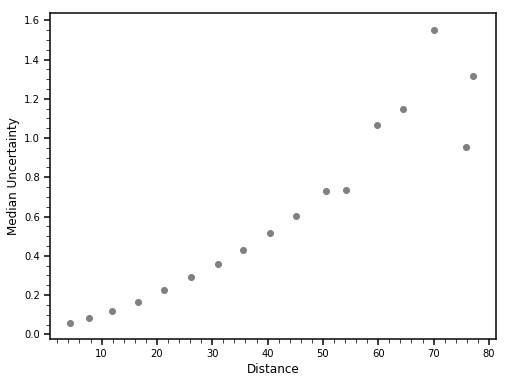

In [13]:

dist = X11['d']
signoise = np.sqrt(gaiadict['gpmdec_error']*gaiadict['gpmdec_error'] + np.cos(gaiadict['gdec'])*np.cos(gaiadict['gdec'])*gaiadict['gpmra_error']*gaiadict['gpmra_error'])

dbins = 20

binvals = np.linspace(0.,91.,dbins)


f = open('processed/bhbsignnoise.txt','w')
for b in range(0,dbins):
    if b==dbins-1:
        maxval = np.inf
    else:
        maxval = binvals[b+1]
    w = np.where((dist>binvals[b])&(dist<maxval))
    if b!=dbins-2:
        plt.scatter(np.nanmedian(dist[w]),\
                np.nanmedian(signoise[w]),\
               color='gray')   
    
        print(np.nanmedian(dist[w]),
          np.nanmedian(signoise[w]),file=f)
    
f.close()

plt.xlabel('Distance',size=12)
plt.ylabel('Median Uncertainty',size=12)

In [57]:
c.galactic

#(pm_l_cosb, pm_b)

<SkyCoord (Galactic): (l, b) in deg
    [( 66.46835646, -36.49371587), ( 61.15107188,  46.72996385),
     (353.34638802,  61.47764698), ( 72.45202665,  46.68857375),
     ( 65.02480429,  40.37141828), (321.87250917,  62.30010962),
     (356.40402669,  49.84243995), (355.25317238,  49.68761435),
     ( 70.41488945,  59.91252046), (139.04574118,  52.43878895),
     (109.97630196,  62.20937446), (232.41344327,  67.22246776),
     (232.14174669,  67.78274809), ( 84.0270334 ,  80.86251445),
     ( 48.07161543,  67.9412906 ), (269.90083785,  85.16944754),
     ( 12.93517076,  56.42300861), ( 10.0093275 ,  55.8638628 ),
     (  9.00708454,  56.46432723), ( 63.13780777,  67.55312263),
     ( 14.39948522,  80.82506371), ( 66.74473728,  37.81454004),
     ( 12.7539381 ,  46.92933566), (221.86150688,  39.08631033),
     (222.9873006 ,  40.6789679 ), (148.80154926,  33.96370915),
     ( 96.13880855,  55.36301669), (226.22645196,  59.10701893),
     (151.60890593,  39.41680416), (194.41824154,  24.

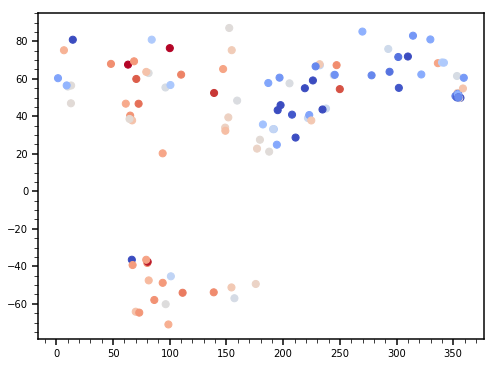

In [56]:
c = coord.SkyCoord(ra=gaiadict['gra'][bigd]*u.deg,\
                   dec=gaiadict['gdec'][bigd]*u.deg,\
                   pm_ra_cosdec=gaiadict['gpmra'][bigd]*u.mas/u.yr,\
                   pm_dec=gaiadict['gpmdec'][bigd]*u.mas/u.yr)


plt.scatter(np.array(c.galactic.l),np.array(c.galactic.b),color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

In [48]:
gaiadict.keys()

dict_keys(['ggsource_id', 'gra', 'gra_error', 'gdec', 'gdec_error', 'gparallax', 'gparallax_error', 'gpmra', 'gpmra_error', 'gpmdec', 'gpmdec_error', 'gphot_g_mean_flux', 'gphot_g_mean_flux_error', 'gphot_g_mean_mag', 'gphot_bp_mean_flux', 'gphot_bp_mean_flux_error', 'gbp_rp', 'gradial_velocity', 'gradial_velocity_error', 'gphot_variable_flag', 'gteff_val', 'ga_g_val', 'gpmcorr', 'gdist', 'sspecobjid', 'sra', 'sdec', 'splate', 'smjd', 'sfiberid', 'sfehadop', 'sfehadopunc', 'selodiervfinal', 'selodiervfinalerr', 'sfehspec', 'sfehspecunc', 'spsfg', 'sfibreg', 'gruwe'])

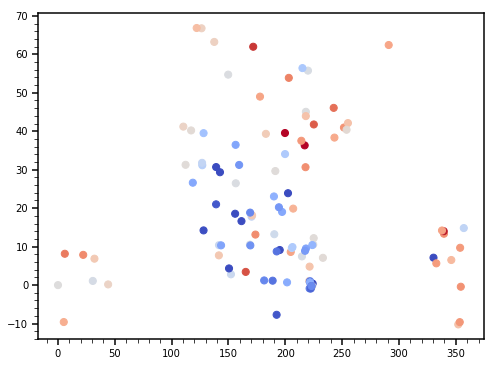

In [45]:
bigd = [X11['d']>50]

plt.scatter(gaiadict['gra'][bigd],gaiadict['gdec'][bigd],color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

In [141]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq."""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)]).T

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return np.dot(p,mua) + np.dot(q,mud)


def return_rgal(l,b):
    """ eq."""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)]).T

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return np.dot(p,mul) + np.dot(q,mub)


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.dot(p.T,mugal)
    mub = np.dot(q.T,mugal)
    #print(mul,mub)
    return mul,mub



def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)


a = 45.*np.pi/180.
d = 60.*np.pi/180.

mua = 1.
mud = -1.

#print(return_muicrs(a,d,mua,mud))

print(rotate_velocities(a,d,mua,mud))

cov_to = rotate_errors(a,d,1,2.,0.)
print(cov_to)


#print(ricrs,rgal,ell,b)

(1.3543164832139731, -0.4072184466535577)
[[ 1.67274602 -1.25125971]
 [-1.25125971  3.32725398]]


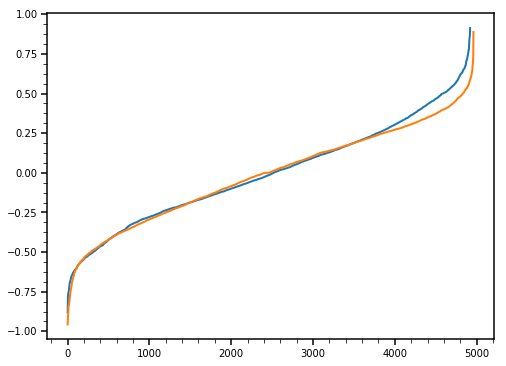

In [142]:
# back out the rotated correlation coefficients
corrcoef = np.zeros(len(gaiadict['gpmra_error']))

for i in range(0,len(gaiadict['gpmra_error'])):
    e1 = gaiadict['gpmra_error'][i]
    e2 = gaiadict['gpmdec_error'][i]
    e3 = gaiadict['gpmcorr'][i]
    cov_to = rotate_errors(gaiadict['gra'][i]*np.pi/180.,gaiadict['gdec'][i]*np.pi/180.,\
                       e1,e2,e3)
    
    corrcoef[i] = cov_to[0][1]/(np.sqrt(cov_to[0][0])*np.sqrt(cov_to[1][1]))


plt.plot(corrcoef[corrcoef.argsort()])
plt.plot(gaiadict['gpmcorr'][gaiadict['gpmcorr'].argsort()])

In [ ]:
c = coord.SkyCoord(ra=62*u.deg,\
                   dec=17*u.deg,\
                   pm_ra_cosdec=1*u.mas/u.yr,\
                   pm_dec=3*u.mas/u.yr)



In [63]:
gaiadict.keys()

dict_keys(['ggsource_id', 'gra', 'gra_error', 'gdec', 'gdec_error', 'gparallax', 'gparallax_error', 'gpmra', 'gpmra_error', 'gpmdec', 'gpmdec_error', 'gphot_g_mean_flux', 'gphot_g_mean_flux_error', 'gphot_g_mean_mag', 'gphot_bp_mean_flux', 'gphot_bp_mean_flux_error', 'gbp_rp', 'gradial_velocity', 'gradial_velocity_error', 'gphot_variable_flag', 'gteff_val', 'ga_g_val', 'gdist', 'sspecobjid', 'sra', 'sdec', 'splate', 'smjd', 'sfiberid', 'sfehadop', 'sfehadopunc', 'selodiervfinal', 'selodiervfinalerr', 'sfehspec', 'sfehspecunc', 'spsfg', 'sfibreg', 'gruwe'])

In [112]:

#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)






In [115]:

# transform to Galactic coordinates

def find_errors(X11,gaiadict,keep,indx,nsamples=10000,verbose=False,sgr=False):
    
    ra = X11['RA'][keep[indx]]
    dec = X11['Dec'][keep[indx]]
    d = X11['d'][keep[indx]]
    derr = np.array(0.05*X11['d'][keep[indx]]) # fixed 5% error
    pmra = gaiadict['gpmra'][keep[indx]]
    pmraerr = gaiadict['gpmra_error'][keep[indx]]
    pmdec = gaiadict['gpmdec'][keep[indx]]
    pmdecerr = gaiadict['gpmdec_error'][keep[indx]]
    vrad = gaiadict['selodiervfinal'][keep[indx]]
    vraderr = gaiadict['selodiervfinalerr'][keep[indx]]

    #print(d     + np.random.normal(size=nsamples)*derr)

    cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                           dec             = np.tile(dec,nsamples)                                 * u.deg,\
                           distance        = np.nanmax([np.zeros(nsamples)+.1,(d     + np.random.normal(size=nsamples)*derr)],axis=0)     * u.kpc,\
                           pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                           pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                           radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)

    cbest = coord.SkyCoord(ra              = ra    * u.deg,\
                           dec             = dec   * u.deg,\
                           distance        = d     * u.kpc,\
                           pm_ra_cosdec    = pmra  * u.mas/u.yr,\
                           pm_dec          = pmdec * u.mas/u.yr,\
                           radial_velocity = vrad  * u.km/u.s)

    if verbose:
        print(pmra,pmdec,vrad)

    gal_latlon  = cplus.transform_to('galactic')
    gal_defined = cplus.transform_to(gc_frame)
        
    best_latlon  = cbest.transform_to('galactic')
    best_defined = cbest.transform_to(gc_frame)
    
    if sgr:
        best_sgr = cbest.transform_to(Sagittarius)
        return gal_latlon,gal_defined,best_latlon,best_defined,best_sgr
    
    else:
        return gal_latlon,gal_defined,best_latlon,best_defined


indx = 0
gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(X11,gaiadict,keep[0],indx,nsamples=1000,verbose=True,sgr=True)

-0.7586968273829174 -1.3916520325706763 -109.064964


In [138]:
#corrcoef.size
keep[0].size

4944

In [146]:

g = open('processed/BHBs_cartesian_heliocentric.txt','w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr]; \
      edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];\
      sgrweak [bool]; sgrstrong [bool]; FeH [dex]; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]',file=g)




for indx,i in enumerate(keep[0]):
    #print(indx)

    #gal_latlon,gal_defined,best_latlon,best_defined = find_errors(X11,gaiadict,keep,indx,nsamples=1000)
    gal_latlon,gal_defined,best_latlon,best_defined,best_sgr = find_errors(X11,gaiadict,keep[0],indx,nsamples=1000,verbose=True,sgr=True)

    dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x),\
                                                  np.array(best_defined.y),\
                                                  np.array(best_defined.z),\
                                                  np.array(best_defined.v_x),\
                                                  np.array(best_defined.v_y),\
                                                  np.array(best_defined.v_z))

    edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x),\
                                                  np.array(gal_defined.y),\
                                                  np.array(gal_defined.z),\
                                                  np.array(gal_defined.v_x),\
                                                  np.array(gal_defined.v_y),\
                                                  np.array(gal_defined.v_z))
   

    if np.isfinite(np.array(best_defined.v_x)):

        # redo with transpose to heliocentric...
        sol_pos = [-8.3,0.,0.03]
        sol_vel = [11.1,244.24,7.25]

        dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(best_defined.x)-sol_pos[0],\
                                                      np.array(best_defined.y)-sol_pos[1],\
                                                      np.array(best_defined.z)-sol_pos[2],\
                                                      np.array(best_defined.v_x)-sol_vel[0],\
                                                      np.array(best_defined.v_y)-sol_vel[1],\
                                                      np.array(best_defined.v_z)-sol_vel[2])

        edLj,edBj,eradj,evrj,edmulj,edmubj = jorge_galactic(np.array(gal_defined.x)-sol_pos[0],\
                                                            np.array(gal_defined.y)-sol_pos[1],\
                                                            np.array(gal_defined.z)-sol_pos[2],\
                                                            np.array(gal_defined.v_x)-sol_vel[0],\
                                                            np.array(gal_defined.v_y)-sol_vel[1],\
                                                            np.array(gal_defined.v_z)-sol_vel[2])    

        print(np.round(np.array(best_defined.x),2),\
              np.round(np.array(best_defined.y),2),\
              np.round(np.array(best_defined.z),2),\
              np.round(np.array(best_defined.v_x),2),\
              np.round(np.array(best_defined.v_y),2),\
              np.round(np.array(best_defined.v_z),2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round(vrj[0],2),\
              np.round(dmulj[0],4),\
              np.round(dmubj[0],4),\
            np.round(np.abs(np.percentile(eradj,86)-np.percentile(eradj,50)),2),\
              np.round(np.abs(np.percentile(evrj,86)-np.percentile(evrj,50)),2),\
              np.round(np.abs(np.percentile(edmulj,86)-np.percentile(edmulj,50)),4),\
              np.round(np.abs(np.percentile(edmubj,86)-np.percentile(edmubj,50)),4),\
              int(0),\
              int(0),\
              np.round(gaiadict['sfehspec'][keep][indx],3),\
              np.round(np.array(best_sgr.Lambda),2),\
              np.round(np.array(best_sgr.Beta),2),\
              int(0),\
              np.round(corrcoef[i],3),\
              file=g)


g.close()












-0.7586968273829174 -1.3916520325706763 -109.064964
0.4127157609273524 -1.725804748159284 -114.26355
1.110003652314189 -1.1507438953498952 -267.740356
3.2742635383346705 -0.6324603879219592 12.118999
-0.06152016407713824 -0.6727165849563455 -151.867523
-1.6764348641304005 -3.113186543458136 -163.888321
nan nan -294.876831
0.3613681592879222 -2.1409778394053878 -177.854019
2.3755577573724818 -3.368695909151434 -180.588104
0.6063821170046999 -1.3823938791336314 -21.890129
-2.0782918013080565 -1.9854873209880717 -273.681213
-2.9754925478389245 0.31031197846046 -42.50742
-2.033118498568421 -1.3357478911374319 -72.127792
-0.9817884720743959 0.4500776037004206 -440.15033
-3.407021449135923 -1.0807575269522958 -68.515976
-1.2535475680437436 -5.92730611656557 -320.506256
-3.517341453648476 -0.11486610096235336 -69.223457
-4.183027096392042 0.7603852152652042 -46.041969
-2.564676582017726 -0.6524709816786112 -73.335564
-3.2818890779887697 0.5184810188328575 19.548796
-1.3672321560474805 -3.1997

-0.4436986519454104 -2.2922245611448417 -184.17807
-2.3765536163826595 -2.59873046545233 -152.09259
0.10804896523021104 -1.0745943790053638 -215.266388
-4.329030847229553 2.4854711658057536 -109.333328
-3.0597077017315373 -2.466853318699697 -264.885315
-2.970606775819758 0.3474231809693835 -17.965546
-2.2009915105650872 -1.489158463570368 -85.783493
-0.46715338294755804 1.032709607129494 -224.029953
0.7676731399679511 -0.7740251110121479 -186.895325
-1.3702864604388145 -0.8538385202359061 -134.503387
-3.182669736546047 -2.70100915312905 -22.005014
-2.6946655943133058 -0.8399598229382461 -329.668488
-1.869729279548134 -0.42456847649630525 -295.945618
-4.063131073710801 -1.3722297903570064 -38.288857
-3.1139348941297045 -5.5142046756304435 -276.296082
-2.0925873354153217 0.17998562934645151 -60.196396
-2.53677113870843 -1.0786361952207792 -52.367455
-1.8776118709884142 -2.8711611418554623 -219.552094
-9.320989299565962 -2.9343139136748224 -3.756706
-0.8999348949325794 -0.9678033598937081

-2.858628238104785 -3.3903343263000143 106.366226
-5.513350546732443 -11.117720188102103 -32.254112
-2.077444234825813 -1.4684669422090588 32.911839
-1.0642142365607812 -1.0343314050441816 -73.020554
-1.6903917973738345 -1.6246827194399163 -31.605923
-4.981401023947832 -1.6514340582847038 2.20939
0.5145197524744094 -2.36986713737989 45.700562
-0.9781299859516019 -2.8280888475781953 -20.466341
-5.053432510870241 -3.3376561091603247 44.480385
-0.22597342181018865 -1.4572368014612147 14.072348
-1.5774407780791182 -1.8775621482469815 -64.982231
-3.570309277974214 -5.2679422129006275 -13.08081
-1.121433448793801 -1.8148213814028886 -20.606253
-1.3723814164007426 -3.3560651331754014 37.222046
-2.394051650683756 -3.670893080584598 -56.823128
-1.3126866414509708 -1.983644218718923 -69.3433
0.20365834611087852 -0.46449822508228733 160.633133
-2.380148258676592 -2.0554043347819007 -144.126099
-1.6675557449766754 -1.632272417673663 279.640991
-1.8473129922233564 -0.38678107165457726 0.902916
-5.6

-2.698246026067104 -29.92049206893978 -115.103836
-2.9584238411453803 -3.4290905043444835 50.736843
-1.5084027806347005 -1.8878283812269996 1.114483
-1.0141689026455327 -0.27833704311923513 -121.848457
-2.6254927956731025 0.5904275536164756 -181.691299
-3.6531436978601115 -8.273056599660544 -265.986511
-1.252465555186936 -1.4450971250706202 -116.113419
-0.21704797564087064 -2.553016594576439 235.110428
0.10919252878518548 -2.590518166413431 -91.364517
-1.4283482100512244 -2.1829279574807114 -204.334686
-0.5097847556973243 -2.5739691706841805 -51.166592
-0.5373664602953286 -1.0675163460169366 -68.937599
-1.7578678394550487 -4.469507181126025 -158.451019
-0.6344622259811838 -0.2978322562065765 -95.31926
-3.1169928071406874 -2.1455068286955044 -241.568832
-1.626300080610397 -0.7776645347970795 -189.182159
-2.5622726707234973 -1.8024895211974745 -101.494659
-1.17511332840335 -2.1437371633849076 -160.998383
-2.5454137247930557 -2.26602335685978 -92.897354
-2.543964275280672 -2.0680549325910

-0.9852975667582342 -3.800178895116927 -7.864954
-0.6297729993467021 -1.4039153955678005 -95.601128
0.578556960544762 -3.3408705772165126 158.765884
-1.3322697979374023 -0.88502440412761 213.584641
1.0419902895321609 -4.399811606353178 64.419495
-1.4673868556847185 -3.3887267381309307 -18.24308
0.7845403829468158 -1.8673634122156852 -65.831711
-0.21527681825767425 -1.7698215809097662 127.908096
0.036790352912074484 -2.692382898980321 -24.739021
-1.0235548828827548 -2.7520491313211406 -10.682017
-1.922817489987895 -0.7099153705353476 23.478006
-0.7163337314031656 -1.39366272067589 233.706726
-2.6277743465060914 -0.7276172915283324 307.79837
-1.0825311649204261 -0.3544945709211463 172.731369
-2.822222639352624 -4.776605171895474 146.390427
-1.0335705593467854 -5.253112204494348 -89.808708
-0.6572708105579086 -1.4234639198364494 163.296524
-2.3157559383001876 -4.257353669768442 5.185946
-1.5327821487802875 -3.9616172835502144 -3.246108
-0.43392114067026066 -1.4707055144922585 184.112869
-

-2.3329678829919502 -3.1376290264982747 -78.06691
-1.3260835072911674 -1.510388251718929 -87.464447
-2.9740479478609525 -2.9865701100284174 -106.128204
-1.384621791535865 -1.796896124212049 -27.400496
nan nan 153.029999
-2.2674590301637254 -1.9969103341864771 54.278362
1.5654803408487046 -4.800232054056039 -37.032906
-1.6293847863798319 -2.1372062646293055 -163.885834
-0.45079060699213647 -2.256074057258825 85.36235
-3.279156265700318 -1.6475094136885928 -17.768951
-3.7688233572963004 -2.003641700548567 -84.006638
-1.6916710641450878 -1.157530449966719 142.085144
-4.846992556328326 -2.997201546145247 121.663864
0.6290864756887011 -3.3278789795703614 -75.71907
-0.012753362786850242 -4.26890951735223 3.158755
-2.9857441709467776 -1.96962256002938 -122.161133
-5.258914857497536 -5.808724380704864 166.752243
-1.7420829230244963 -4.95204913045002 -12.929723
0.821833258842773 -3.7685120863179664 -66.745529
-2.5793973808798913 -2.708903820769879 180.941422
0.662463627378092 -6.499646510820592

-2.2533595362495236 -4.3874239956259595 -33.282803
-2.4059043866685914 -3.486534315560173 -156.926254
-5.333400670006069 -7.018202692405857 -97.370888
-1.098092577279849 -4.225476030929196 12.252741
-0.2258598118490423 -0.7817870498318309 147.770081
-0.2106792359896706 -1.5079205112898508 179.464142
1.8760030933266447 -4.345735586656267 -180.854401
-0.8107234719135781 -0.5108404926189853 60.222198
1.1317485246031969 -3.9052210169441173 -237.539734
-0.9552736279921248 -3.07425490711504 186.858887
-2.151098108419137 -1.4046630930842066 -23.353916
0.28574292259917394 -1.0724684951955377 -3.448943
0.9661304089271806 -4.866614576008285 -175.770401
0.4518857341720297 -2.4245359338941386 -14.318464
0.4114437212403077 -3.5756461404310333 63.036236
0.6066695974645286 -1.0490118292773989 34.557922
0.8351559204551444 -0.2600812997966555 -63.990875
4.372776623323641 -2.0887411576717816 -14.92277
-0.21197163394097057 -2.4802262196561276 -152.048096
0.00522600851883826 -1.9881710625995164 -151.33798

-1.606657836799894 -3.6168082907249333 -170.000778
1.6318559587650499 -3.912274880269207 -30.54674
0.9346808447300584 -0.5278874304039203 -90.420845
2.9324693633919314 -4.073790199751838 -61.752182
0.7011442992465191 -0.8362720335061906 -172.939697
-1.3852392333270904 -2.859006644280099 -105.402687
-0.10946621571351282 -3.398002894321129 -260.902008
-0.6902984028898821 -1.9273073996726335 -33.582047
-0.36149199169909885 -3.4378343297488234 -4.264759
-3.036587806752672 -3.1913030923823977 -163.48204
-1.3041446578484144 -3.9844613835379152 55.721191
0.9835897511013432 -1.997940916193091 -130.231476
-0.5759914982658628 -1.8511795970594471 12.251777
-1.9950615542123589 -4.374458969188201 142.488174
0.5958831607544754 -0.7305354008149404 -181.986694
-0.6439719445398755 -0.20588719679404385 -209.573105
-1.2651663426991724 -4.04368561620199 -102.251534
1.9719663476034284 -3.043122659773616 -24.543941
0.970158053515473 -3.28357840163369 -73.886864
0.9645490777931977 -0.5230679879614175 -110.37

-4.953927109329285 -4.445176315392471 -38.651287
-1.5340030805454163 -2.2408107395789854 -187.372086
-1.5373703934473208 -0.9753091483678495 -266.190216
-0.5569463057603877 -1.582494229594091 -237.298676
1.246984870628268 -2.3462097260239805 123.100342
-1.3769680672458733 -2.557326864879204 -189.055923
-2.2127676955231577 -4.71635997723777 -221.27832
-1.5792603076929694 -3.337515887579656 -58.760914
1.3496268447795374 -1.712340406748896 -347.209808
-0.3339232802523886 -3.325398348767542 -162.537003
-0.6786699561931826 -1.5801218406957713 -131.427551
-3.5866035986141216 0.5617267191063595 -232.872864
-1.4159909458507962 -5.180241672755214 -307.208191
-0.4357134415674566 -0.17252721360824477 -161.763962
0.11855635088511321 -2.2636727210807477 -80.581711
-0.05174658018536338 -2.610871770371037 -71.444748
-2.052878264014973 -4.004995434006955 -28.596416
-1.8775661401103478 -2.4803110499207923 -90.562057
-1.6124182693476898 -11.181685687261728 -183.655685
3.069365575023339 -3.75458039449573

-0.8731832996615826 -0.944647883982377 -355.410614
1.7851221194041118 -0.23651132242484232 -21.978035
-3.4572662953562063 -3.463113985405504 -172.346085
-0.7248817545355266 -4.221939180201779 -216.11908
4.100529512798073 0.030016123537151426 10.305062
0.14166681550191615 -1.4483220618321684 -15.030208
1.4817664203908245 -5.672065677377676 -62.657879
-2.8117433212364475 -1.9970432372340166 -8.53618
1.2373244549913571 -2.8692678126291966 -80.821846
-2.2616479981257096 -4.074253630304695 -247.358154
-0.8381935738357498 -5.386559939485753 -262.015991
-3.7824502010515917 -7.81971651342962 -115.324646
2.8428276732030295 -1.8257555129811265 52.953945
-1.6954906114265402 -4.098650221514739 -125.569931
-2.6882980816023823 -9.79796942713324 20.965137
-1.1117289666105616 -3.813102845444729 -31.24494
-0.9134046875677371 -6.015110381829493 -127.213654
-0.31217888481375844 -8.754529132409697 -15.483456
-1.3409488433006973 -6.695734350814813 -224.370972
-1.8211106681734004 -2.5850498233124872 -103.32

-0.8059066775991703 -2.5391223624848935 -84.783043
-3.501069935073559 -3.6860245788345805 3.25106
-3.4812594549202016 -5.057783491085731 -99.272804
-1.3041384933348137 -0.8101094482700696 123.810661
-1.2928881165435764 -1.4188597427461629 129.374573
-0.5870634757316107 -1.468438907549328 200.395615
-0.7557666175940897 -0.765803040289171 34.600014
-4.890474397286512 -1.002012185482212 43.716919
-2.636941256063089 -2.0619709023253785 -97.55027
-5.661488025781239 1.565357788782153 48.388725
-2.9007653765649386 -3.6342476662646517 -60.895691
-2.4112637775596064 -3.7848629915716554 25.991243
-1.9005605131792558 -3.9001229158944977 11.140195
0.15498247126539283 -3.6202587335008416 -49.335812
-1.2858273516007317 -6.706705271575148 -42.27037
-3.905492208182489 -11.135166333141111 -197.019363
0.6410276622526756 -8.187351347957522 -281.964722
-4.434200820903226 -3.6303518725938972 -173.455292
-7.27970164856652 1.1312684178817003 -43.795334
-1.922236263340689 -2.934829207942259 -20.048927
-4.2413

-1.9797789989755838 -6.271301294091326 -133.970474
-1.2363046022450197 -1.6639991035444759 -66.210876
-0.304619626879039 -2.466770799297435 -134.614044
-0.38900487150411267 -2.5057636334432916 -142.387207
-0.4735334636213701 -2.5709251003568907 -142.416382
0.04270790745436037 -2.54543799063034 -128.776184
-0.14684791737085134 -2.5403791815253927 -124.762291
-0.07621483044275068 -2.398638539835906 -134.589294
-1.6376949744386455 -2.6127270004463656 -114.245399
-0.5556368999922663 -2.418576043677485 -133.367615
-7.724341366776992 -8.259506068122523 -159.798996
-4.232693594078196 -2.5787962092764847 -54.181129
-7.8201019563620235 -6.055691386089963 -22.745138
-3.3851061296498655 -3.9493865577409295 -20.508514
-4.5504049577008745 -1.3968443075428199 18.613314
4.098769147741802 -9.744410219293414 -147.057816
-4.9702541688058455 -5.28955139629544 -11.177616
-2.702180961996793 -2.9215573001236392 -145.102386
-1.3318067776704268 -6.55775519164939 10.055778
-3.961853048848331 -3.779274787929791

-1.1202322806486427 -0.09702867594740144 -38.951481
-5.574158812873916 1.009748245977553 -168.88649
0.3598675976238347 -1.029613428818966 -107.141571
-1.4936198446717117 -3.495544916000279 -119.945
-1.4893451516263794 -3.2104191816713987 -84.117813
-4.061774156046516 -2.4132034862641696 -196.272629
-1.745044411257769 0.8565197263530432 48.52866
-1.0571265710795188 -0.2600889875074501 -92.13903
-6.445800036591286 -12.274203904440537 -212.233963
-3.0547624432659917 0.14419865625674821 -197.035141
-0.7942812471343285 -1.1230344388764102 -291.352875
-3.4559152342508144 -4.2600898531397835 -188.286835
-3.05735139993531 3.2800594203230435 -79.843979
-4.150125708428618 -0.31023753872824555 -136.115082
-2.0180159856591717 1.4164375803583638 -166.478439
-0.9643386023715584 -7.755522082150841 -53.122311
-3.2707746878257664 -3.4416706207134684 -324.36795
-2.9607208690795703 1.2762629388314155 -286.15564
-7.633779815899039 -0.6418624518782587 -10.811628
-3.759558790868068 -8.208237920370166 -50.57

-1.2019368555328862 -2.322735369472267 -111.846954
1.1559340506955065 -1.8253752141448962 61.012764
-0.2794578526175625 -3.4883423403963763 12.653428
1.146639241889909 -0.29146025262025677 -59.644779
-2.133116930349835 -1.2890558541705266 -142.344116
0.370272757800146 -2.9059002940429637 46.646431
1.6846203696192912 -2.335241610594734 245.01297
1.1412100687354627 -3.780482916215399 35.107239
0.42062214740262566 -0.8709715826108761 55.31852
2.3625352504974977 -5.406024437682621 -19.480276
-1.0124366950922215 -4.288967466999889 -71.319199
-0.09782180176841415 -1.3779395024977141 -64.514656
-0.27177595505769986 -1.601257735421098 -55.379608
-2.255852837383248 -0.26652333983797916 104.510521
-1.1721371824738578 -2.7026909307890006 -95.978607
-0.8563944167891586 -2.5447028885398777 -66.990356
-0.6680905961582018 -3.474402189806319 37.425648
-1.5305681260892001 -3.4854123701874316 17.948538
-2.317928305141013 -4.529123249457881 -2.905335
4.912748447588677 -4.480007058343835 -277.782257
1.686

-1.5310879466328966 -3.2158013762968993 -237.918854
-0.6672703950322901 -0.6754520502271919 -290.656006
-1.3474580274072911 -2.2256687057223696 -148.206284
0.3598264988271166 -3.02165713055125 -97.313583
-8.124044186829956 2.9895318878895396 -86.855484
-1.6079355262710142 -2.4417237244095706 -73.876556
-0.8247443777323814 1.7220450254266026 -121.328117
-2.2541389801795217 -2.4152077970211288 -381.980865
-4.286620314198087 -2.200284213848861 -167.441391
3.2102382529834004 -1.0053949231197818 -208.780502
-1.3999898386881646 -1.0389938354949557 -273.233215
-3.6878310972299246 -0.7395513031144105 -123.206993
-0.6959500140089798 0.13911542917707084 -153.236191
-0.9090663529717833 -3.038562389391177 -263.723907
-3.710533737607842 2.0753009017963104 -85.465134
-1.4589797612533364 0.7296169282324014 -20.435675
-0.8698179943168363 -0.7806986697271415 -359.946991
-0.4885370555956692 -0.755779288011079 -197.518723
-0.24030037437257493 -0.23441641989639703 -200.974136
0.4495901162037604 -0.8036759

-1.5497082494626466 0.6626324107449781 238.962509
-1.254670614761262 -1.6468015781183667 247.302063
-2.0654383572776833 0.136978635265178 224.414612
0.6297337033002929 -2.199281422419573 142.859879
-2.665409033689654 -2.7650418720968855 281.944
-3.701069109939636 -2.7205816750008673 215.388443
-1.4425030811988604 -2.017262479083753 199.284454
-2.0488178056290622 -0.3222939766313445 89.87027
-2.5715783131392596 -1.0270287450403726 -158.281357
-1.1385331592068808 -4.069278264040617 -112.135262
-1.6773133023852986 -0.8758674459884965 -28.999302
-0.0733956446649477 -2.5178046226281774 112.606812
0.05205537702733007 -2.2946033369480086 84.779633
-0.5037165983683624 -2.1616762062967108 183.498962
-0.32107385678813605 -1.5393812566805638 122.981125
-1.2615933662725762 -1.5499895711039249 219.048767
-1.2510094330573405 -2.775537927174918 52.01524
-0.5044229918928823 -2.1144133423758333 93.22509
-0.8701094244031992 -1.3272997639418744 235.345535
-1.7982516142088991 -1.0771958880501442 327.75540

-1.8894225072075814 -1.7531353446809508 199.402115
-2.8018733226954287 -1.6065919932506805 68.827881
-0.7249298573274369 -3.0079116320573798 -49.257507
3.5401189396059363 -7.380911003195505 -34.617664
-0.5699270735720985 -2.899010727496951 -37.79961
0.7503757926209131 -2.7706503323724583 -46.645672
2.6707585170833483 -7.303533187145614 24.128054
4.4007600396013915 -7.8294852830336295 -71.798767
2.2485146569634766 -4.558750159442346 -205.345474
4.148342886645122 -0.6913481733504673 -285.271606
2.311203336711678 -3.0553468833206003 -112.456841
-1.174169655684878 -2.875952032692707 193.457108
0.9809631063344023 -11.365905830988417 100.701523
2.3988495956139317 -7.6698285653447265 109.078995
0.07731750160461873 -1.5939863730649342 -163.886093
0.026290002508624122 -7.300165384420202 117.175774
-0.1078947102346762 -5.452997383633398 -372.33075
1.1708541106599073 -1.7294095295390455 -168.583435
3.0237944166962394 -3.2285756140125113 -122.949692
7.638420731812919 -1.387208155419369 -97.32132
-

-0.6745828616087488 -1.3083912254705186 37.789501
-0.6037602783846798 -1.1662831377490026 46.272755
-0.40259370389289006 -1.6314085277281105 -62.055408
-0.06062490943048769 -1.5475529534234091 -58.160549
-0.27996234666191266 -1.219261300604887 -56.575916
-3.1173674600663728 -3.439441408622803 125.710175
0.32332774717325663 -1.665719804531077 -66.638344
-0.5858353393863254 -1.3175713787331207 -46.443703
0.16615868564549208 -1.0393598579809011 -48.855541
-0.24812350186102794 -1.339931746772722 -63.843929
-4.651297060369028 -6.205239969935172 -1.129573
-0.36099120365366505 -1.463345140907689 -64.02343
-0.040803254564100874 -1.3651341042237424 39.822414
-1.0473514410428741 -3.820238569861998 -107.476227
-0.9865463583685262 -1.803559581668793 9.266538
-3.1447257815203113 -2.993909253224823 112.629486
-1.3019709035542575 -3.835983202044991 102.26104
-1.7104873626141137 -1.3051730955118592 -85.218391
-0.22339792577558418 -3.832830438683624 -71.58728
-6.759821419666192 -2.6919712294672133 30.6

-0.7959139719335826 -0.1986710404486845 190.167877
-0.4752816315104131 -2.1941482537192507 174.129623
-1.6012369559689348 -1.014636125289136 -27.206291
-1.9149197339446877 -2.473619361452223 41.228512
-0.14876773649206065 -3.9254358381853116 101.174484
-1.6788259509561014 -1.4980902933618996 -59.350334
-0.37427572798511255 0.3419709011430777 192.942627
-15.49155334836713 -32.89127175856986 305.323883
-1.238433914384059 -1.7011606894905227 -28.265688
-1.4778615404993165 -2.2280434576472046 79.68924
-1.2075577854367374 -4.059584024032636 -89.98867
-1.0797854696192979 -2.2551578320677867 -72.593834
-1.7029611439609582 -1.5313180464240834 54.733788
-1.0199242407621159 -2.690696977270507 -80.619347
-0.26124122958563323 -2.048687276884983 -15.829902
-3.3375165194777727 -3.2767659834751957 182.283127
-0.9265097884437514 -2.9964335720751905 42.644257
1.0922477200821858 -2.227773975350085 75.679169
nan nan 201.169296
-1.7768624720939474 -2.4032307876962737 -2.917215
-0.007857764983040194 -1.283

0.2836257454548587 -1.5329224548880265 -209.226593
-1.2908194510574438 -2.956145470897633 -111.820892
-1.0212720824003003 -2.8110391527656002 -128.812485
-1.5640234669430326 -5.444013238642659 -34.539886
-1.3748941994715707 -4.169439596547061 -395.35434
-1.1385199363061609 -0.15389668846162036 -11.964497
-2.8467564581011766 -5.285629826669646 -72.313652
0.34667576755131974 -0.8924556736414396 -44.644814
-2.472346643994697 -3.5849803794239072 -385.503143
4.66502851227824 -6.309914090535595 -331.748749
-6.342431034527816 -2.4735446139817157 -221.95784
-2.193928169054208 -2.0796866624042023 -349.005615
-4.588978228872147 -3.5946633648722144 -343.971161
0.34003934928078633 -2.224987523868566 -329.881195
-9.712713521976218 -8.28048683014366 -122.04763
-3.3397718091769097 -2.122490829122729 -176.046143
-8.017576855057959 -11.673261223368005 -182.122772
0.4249638912842396 -0.5923074505790964 -140.494431
-3.304383600010771 -2.6679249675795043 -240.082214
-2.534432106276321 -1.6642648794884254 

0.17797417211740607 -2.1834213056900564 -184.719711
-2.1744193600205204 -1.396233102054973 7.824917
-1.5122251139512766 -1.9838169150726799 -141.001984
-1.3489842830563057 -2.724016122665919 81.074287
-2.646481634100039 -3.8275048615834915 111.998634
-1.3297027621830833 -2.277813615460513 153.342194
-0.4849296748293016 -1.4816873469737706 202.837631
-4.7769472159267465 -1.6904374911852358 200.717239
-0.5877573045682175 -0.7326311723757024 219.512924
-4.439490190751548 -6.9435686347719585 294.619202
-6.742799644026474 -6.438884795103437 224.810074
-1.457073940300595 -1.6740553768168367 -179.833115
-4.633861999005017 -1.5388092333154146 -12.908373
-0.6304683494972579 -1.2165480472826817 -36.823433
-1.3846742730344617 -0.7624757912750998 148.894562
-0.8643520671226418 -1.3874398545521214 49.890537
-0.5876025339098027 -1.2406209075164363 -12.764511
-2.866694440091337 -3.985519013359892 -13.852365
-1.4558077152880613 -2.4797792483542977 41.418453
0.005803500029155417 -6.10667414594151 124.6

3.580628733353304 -2.045961708418571 14.592385
-2.1501567268869457 -7.426660587514067 50.184692
5.119958918010116 -5.965060271281979 95.85009
1.183754543743181 -3.6243358570949495 155.916733
0.10626230355712485 -2.9931560007166547 123.679352
-1.5384668754803135 -2.5119048373643 111.403343
-3.1235224948578417 -1.5989097671637413 101.859108
-2.241060491530953 -4.697292261889688 63.195671
-2.5172993977801355 -1.3426454105483565 46.960175
0.6112387246823539 -3.523111267348118 91.90873
-0.17574546624469028 -1.307614844945674 79.401421
-0.8344034150211054 -0.8331435561326721 164.120239
0.9980166876198495 0.18549668482715495 -47.172272
-2.4695190465544377 -2.791789883380015 174.369949
-4.678163928865126 -5.528519937431315 205.204956
8.260469603059478 -2.069463906758198 -11.301492
-2.2147887243347264 -2.7952337126880344 -78.211098
-0.9739637987982823 -2.236544137545478 -10.210329
-0.9359149110728866 -3.4134725972404842 80.61692
-0.5490074427239671 -1.6113668970203174 188.854034
-3.119466042079

-2.6392798500924775 -4.079175839297973 -165.955383
-0.8326705385542212 -0.5251698947979969 -192.847168
3.150769312308884 -2.9051878139200635 9.314092
-4.888157327577894 -1.1921139059015242 -178.365173
-0.16484487912526513 -1.6437528390519474 -187.735733
-3.0347664652213484 -4.016422242107213 -361.207245
0.9015484959425804 -3.533471790803061 -132.252197
1.1697053890687208 -1.1180316505572165 -132.948868
0.5684640705733491 -2.0775416270561524 -98.16655
0.6453046882230222 -0.681859229349407 -138.043839
-0.3543513478387462 -1.0072931480206013 -251.559082
4.661894071030874 -7.675790265913843 -244.959381
1.0981905201863749 -2.395283341669907 -313.140961
-1.3406450937577714 0.6625713647608441 -269.075043
-3.961792501807535 -6.406216622595456 -186.3759
-0.5846051535119022 -2.7575002697830238 -322.495789
0.3423679986947295 -1.50666340406587 -358.588104
0.6897972419123553 -3.9160458789032098 -157.08606
-5.254071981185238 -7.588061939331911 -198.29715
-0.9535036553778414 -1.2487263539099158 -41.5

-3.0546078692234717 -0.6050673878359908 143.2164
-6.806584192610503 -1.5754800762050978 -77.625069
-1.9309267295118981 -1.2466392763976897 167.925568
-6.202133634317485 -6.171129848774356 -125.765282
-0.30237404963905795 -1.0288700714810592 -193.398148
-2.714993450873899 -1.706758369622097 -189.705276
-0.60165230439834 -2.3576009451366073 172.688995
-5.3420361812926345 -3.584187859327196 -27.580347
-1.658461591150511 -2.8122840626071017 -179.394455
-5.348160405270915 -7.039607516932771 -148.273361
0.6819708150646635 -3.219302746585605 -66.325523
-5.727259539592655 -6.08980039444063 -120.18132
-1.1493570469792986 -1.4746508311313327 -116.295364
-5.167573641287257 -0.9302907464969609 167.947937
-3.533030266686441 -4.007018366142367 -146.720779
-1.863045501249094 -1.23154840023438 22.467987
-2.0278250216527276 -1.2346645979185846 -68.955139
-1.8133041801840393 -2.428488640006462 -176.169647
-1.3613871012828713 -2.550932147075001 -214.742874
5.861254359651231 -5.35668751136436 -12.990332
-

-1.1004520270491884 -2.310445896263447 47.389519
-2.564138006692979 -2.8873593866718275 -95.396187
-1.8993912929232382 -1.9822194069982721 -14.519235
-1.0805278043715125 -1.465116613184502 -147.19574
-0.9220678307857638 -2.056278814560478 -155.047104
-2.5400065986228437 -0.335712382184378 -34.721264
-1.2002934054650252 -1.57559223280841 -216.078812
-2.1981174858138997 0.5408270516107319 -121.911812
-0.7030014488335238 -1.0866121947926453 -91.236954
-1.1237986665250026 -2.9686053511610995 -100.094391
-1.1171618374629835 -1.1019149998206998 -112.601509
-2.1402042497872484 -2.650492477996443 85.715202
-2.3628754677416564 -3.465400121483793 -238.397003
-1.0825568623674 -3.364168292596455 -251.40358
-4.752651266051643 -3.806306201898046 -149.876816
-2.5920890389809808 -0.9574463827726188 33.46785
-3.450641060219307 0.38569754543435125 -1.095164
-2.9339721108434147 -2.3110258299172117 -96.721809
-7.143355980347019 -1.8426857842663449 -63.887421
-4.688478302681835 -3.4239580335664925 -239.632

-0.3417906699614657 -4.433212511397318 137.679779
-4.00347596771093 -6.1910074148881 -152.378372
-0.24492773507181664 -5.857637884956569 184.404907
-1.5452781299164207 -1.8871951936102438 -99.749268
-8.633468958333083 -2.5456348523370123 38.029793
-0.09653386158441746 -1.6080696179335479 81.712784
0.22485589485430701 -2.0643367044009295 63.333897
-0.6532788375271007 -0.21899224797527378 94.589417
0.06343933886578695 -1.6605264611690955 53.690781
-2.4304348165931318 -3.6543098900828404 138.300995
-1.3185332732692232 -1.77751050175991 144.340454
0.40561167177362023 -2.8160814581222633 252.932388
-0.22416642140509768 -1.7421036306245608 167.38707
-1.1163113536805356 -1.7285719071891443 224.219803
-0.16100517914783385 -1.684851464912553 105.405296
-0.0512800266850314 -2.314451919972763 72.597107
-3.095442085453696 -4.129721285104277 349.602112
-7.002584869192671 -7.387885474798679 164.258774
-0.7108065287266513 -3.5186424734392148 -125.487488
0.6999107898510797 -1.5567323751210362 31.86341

-7.367726850242923 -1.557912030000262 32.57317
0.20659106836338925 -9.97190235629229 -2.667865
-1.4849929022855926 -4.6459884814219405 -83.169914
-0.7019314885183905 -1.9083120707434287 -207.194168
-0.30266866207218845 -1.6497639300148288 -241.828903
-1.7497077009246809 -0.9147020866347287 -149.071777
-1.9047468349776335 -1.0097437273175762 -69.830833
-6.666459316686202 -5.232478124208585 183.440247
-4.074679994409997 -0.37504105646602603 104.135078
-1.3030037597581543 -2.954425799764736 -185.34935
-1.961846995004807 -1.2979215872468552 -188.364792
-0.9352220975718011 -0.6797645940803335 -73.670967
-3.14075283597686 -2.7416478226275354 -68.867912
-1.9184658453644317 0.0038403878358453255 -49.641891
-2.848979589587418 -1.0334111785491515 -14.287322
-0.4948330206586724 -5.3394248102981585 -59.764626
-2.7616255830656913 -6.742428420448277 -100.020409
-3.8925398691545547 -4.083925889344304 32.691616
-7.6821432537537 -2.829647066390891 -77.778976
0.7686775165286248 -5.66024215244118 -137.37

0.07700451110984297 -2.36445502080089 -17.527061
1.0975173455816958 -4.863816344941744 -94.421074
1.4669117251045036 -0.3148042015262587 -90.741508
-1.5987207570770365 -2.1359523982537207 97.677971
-1.0323800907844911 -2.70357600976053 -76.189224
1.099777649811747 -5.334640103364932 147.203186
-2.875716093956582 -4.787905582061314 -10.18169
-1.4815564142123592 -3.6099128243763228 -79.381783
-0.45473246663866806 -2.4130137027997542 -92.560501
-0.7359379616206148 -2.1544580627273353 -95.384743
-0.4975308999121694 -0.4874699687305528 460.619781
-0.39129698497973964 -3.5937811983129273 -34.990387
-0.5525720391355502 -0.37072161988178937 58.176186
-2.1110057507071938 -3.297340628402753 127.831543
-1.4585120764220472 -2.5212853008658636 103.952568
-0.07194561486756505 -1.979691514878848 -22.87763
2.8476530391165826 -4.6508042196739465 2.475222
nan nan 120.76561
7.1761022589324455 -10.054612334502945 -75.229523
-1.5033324378874928 -5.35625104326469 131.925858
4.438152405475142 -6.084315804849

-6.9256368821520855 -5.307366651630382 -6.657524
0.803214608923156 -6.84920837123811 -21.676676
-0.37997181567804417 -4.16135084448638 -187.059952
-1.7718020744914411 0.37009093055419645 -64.589584
-1.0096452620803795 -4.501599129307215 32.611294
-0.7735168774823745 -1.6326850615396777 210.130981
-2.9884129335338363 -1.3503954435671592 162.046158
-2.8049410159847827 -1.7803879813479766 35.959061
-7.195260593765604 -0.934560530607236 54.703201
-1.5965870495085017 -1.6089777098689844 33.88459
-6.814189329694772 -1.1396575863522758 -56.877018
-1.5387457748650564 -3.145563988601088 -96.18502
-3.7073910003951798 -1.8722426986709761 -213.256088
-13.73964172942008 -7.132925679235056 -110.139862
-2.6233167790434155 -1.0455967284484398 167.478317
-0.5040766346249907 -5.205902715400334 -111.545235
1.6828008912008756 -3.557050431997894 104.037598
-2.1600204903746296 -3.439455867075874 39.667889
-1.347486815429526 -2.5251771885489855 -17.769817
-1.022573146978454 -0.8267998602982538 42.934677
-4.7

-1.2153209102839084 -1.5116420137000566 226.517456
1.7987666713703736 -1.612959920906288 58.251728
3.262714616477492 -1.3380609606422955 245.2061
-2.049234070917676 -2.2981135603693437 254.039291
-3.363307477152665 -4.51927844997111 313.01297
-2.3964506402210235 -1.8111807295519247 143.511658
-1.0147417523779958 -2.4971617000797663 65.529083
-2.619411412279634 -3.519531629562722 -52.640865
-0.8449783198930465 -1.9551501096669408 288.076172
2.472920002702497 -1.953778274919163 41.970043
-0.1408282622478092 -3.1615703703093443 -182.588974
0.26735331974582 -0.9684784447455033 47.425625
3.618710810558905 -1.0536162779472389 180.568161
1.391007701582599 -2.850126494958835 -21.285295
-0.35504064825645737 -2.255596714011206 -124.521332
-0.40664870370651574 -2.855111160002503 -80.577301
-0.49327807878493746 -2.899921817820423 -235.977112
2.4280232945202864 -2.538517738449716 -146.12149
8.2375875038366 -4.425778645221154 -143.384766
0.7309998237242107 -0.2650379124168938 -152.993637
1.488880685

[-1.722 -1.387 -1.685 ... -1.523 -1.793 -1.308]


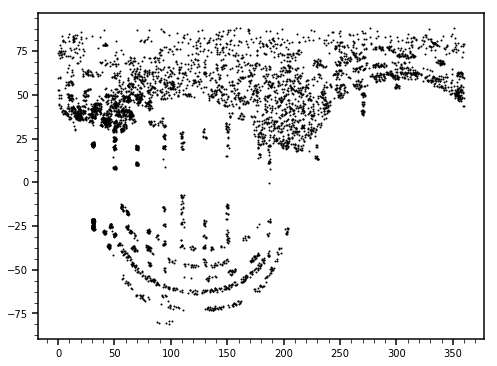

In [144]:

In = np.genfromtxt('processed/BHBs_cartesian_heliocentric.txt',skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

#tl,tb,td,tvr,tdml,tdmb = jorge_galactic(x,y,z,vx,vy,vz)


l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

sgrweak = In[:,16]
sgrstrong = In[:,17]

feh = In[:,18]
corr = In[:,19]


print(feh)

plt.scatter(l,b,color='black',s=1.)
plt.scatter(l[sgrstrong==1],b[sgrstrong==1],color='red',s=20.)

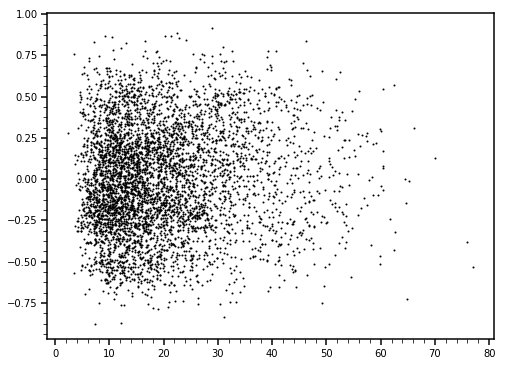

In [145]:
plt.scatter(d,corr,color='black',s=1.)

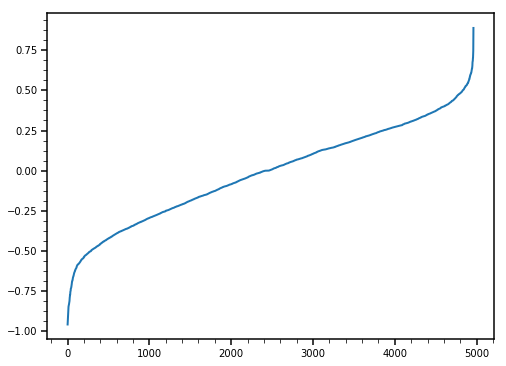

In [134]:
plt.plot(gaiadict['gpmcorr'][gaiadict['gpmcorr'].argsort()])

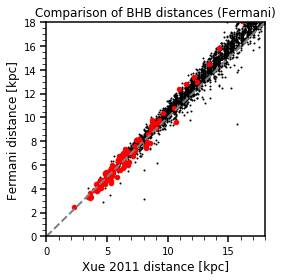

In [17]:
Gmag = fs_mag(X11['gr'],gaiadict['sfehspec'])

fibredist = 10.**((gaiadict['sfibreg']-Gmag+5.)/5.-3.)
#plt.scatter(X11['gmag'],10.**((X11['gmag']-Gmag+5.)/5.-3.),s=2.,color='black')

#plt.scatter(X11['d'],10.**((X11['gmag']-Gmag+5.)/5.-3.),s=2.,color='black')





plt.figure(figsize=(4,4))

#plt.scatter(X11['gmag'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)

plt.scatter(X11['d'],10.**((X11['gmag']-Gmag+5.)/5.-3.),s=1.,color='black')


w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
#plt.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=20.,color='red')
#plt.scatter(X11['gmag'][w],gaiadict['gphot_g_mean_mag'][w],color='red',s=20.)
plt.scatter(X11['d'][w],10.**((X11['gmag'][w]-Gmag[w]+5.)/5.-3.),s=20.,color='red')




plt.plot([0.,30.],[0.,30.],color='gray',linestyle='dashed')

plt.ylim(0,18)
plt.xlim(0,18)
plt.xlabel('Xue 2011 distance [kpc]',size=12)
plt.ylabel('Fermani distance [kpc]',size=12)
plt.title('Comparison of BHB distances (Fermani)',size=12)

plt.tight_layout()
plt.savefig('/Users/mpetersen/Dropbox/mike/Models_30March/bhb_distances_fermani.png')





# d = 10^((m-M+5)/5)


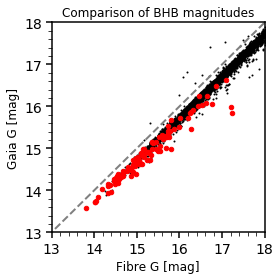

In [302]:


plt.figure(figsize=(4,4))

#plt.scatter(X11['gmag'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)
plt.scatter(gaiadict['sfibreg'],gaiadict['gphot_g_mean_mag'],color='black',s=1.)



w = np.where( (gaiadict['gparallax']/gaiadict['gparallax_error'])>5.)[0]
#plt.scatter(X11['d'][w],1./gaiadict['gparallax'][w],s=20.,color='red')
#plt.scatter(X11['gmag'][w],gaiadict['gphot_g_mean_mag'][w],color='red',s=20.)
plt.scatter(gaiadict['sfibreg'][w],gaiadict['gphot_g_mean_mag'][w],color='red',s=20.)




plt.plot([0.,30.],[0.,30.],color='gray',linestyle='dashed')

plt.ylim(13,18)
plt.xlim(13.,18)
#plt.xlabel('Xue 2011 G [mag]',size=12)
plt.xlabel('Fibre G [mag]',size=12)
plt.ylabel('Gaia G [mag]',size=12)
plt.title('Comparison of BHB magnitudes',size=12)

plt.tight_layout()
plt.savefig('/Users/mpetersen/Dropbox/mike/Models_30March/bhb_magnitudes_fibre.png')



[ 0.01349299 -0.05644677]


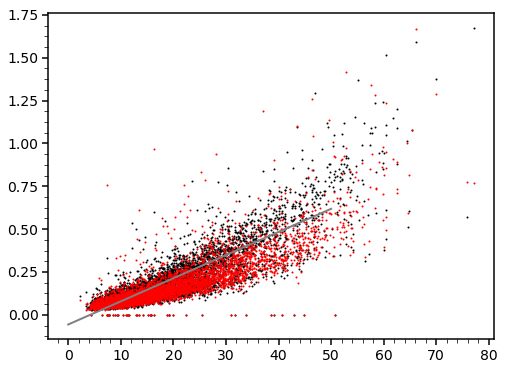

In [234]:
# estimate the error as a function of distance


plt.scatter(X11['d'],gaiadict['gpmra_error'],color='black',s=1.)
plt.scatter(X11['d'],gaiadict['gpmdec_error'],color='red',s=1.)


p = np.polyfit(X11['d'][np.isfinite(gaiadict['gpmra_error'])],gaiadict['gpmra_error'][np.isfinite(gaiadict['gpmra_error'])],1)
print(p)
pfunc = np.poly1d(p)

dcheck = np.linspace(0.,50.,100)
plt.plot(dcheck,pfunc(dcheck),color='gray')




#plt.ylim(0.,10.)


[ 0.20939577 -0.04890582]


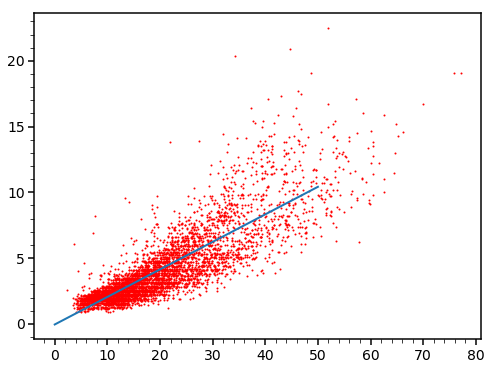

In [226]:
plt.scatter(X11['d'],X11['eHRV'],color='red',s=1.)

p = np.polyfit(X11['d'],X11['eHRV'],1)
print(p)
pfunc = np.poly1d(p)

dcheck = np.linspace(0.,50.,100)
plt.plot(dcheck,pfunc(dcheck))


In [104]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq."""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),0.]).T

def return_rgal(l,b):
    """ eq."""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),0.]).T





def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    #rgal = return_rgal(ell,b)
    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)


a = 45.*np.pi/180.
d = 45.*np.pi/180.


cov_to = rotate_errors(a,d,1,2.,-0.25)
print(cov_to)


#print(ricrs,rgal,ell,b)

[[1.21186271 0.13875855]
 [0.13875855 0.0301345 ]]


In [108]:
i = 4
print(gaiadict['gra'][bigd][i]*np.pi/180.,gaiadict['gdec'][bigd][i]*np.pi/180.,\
                       gaiadict['gpmra_error'][bigd][i],gaiadict['gpmdec_error'][bigd][i],gaiadict['gpmcorr'][bigd][i])

e1 = gaiadict['gpmra_error'][bigd][i]
e2 = gaiadict['gpmdec_error'][bigd][i]
e3 = gaiadict['gpmcorr'][bigd][i]
cov_to = rotate_errors(gaiadict['gra'][bigd][i]*np.pi/180.,gaiadict['gdec'][bigd][i]*np.pi/180.,\
                       e1,e2,e3)


old_angle = 0.5*np.arctan2(2*e3,e2-e1)
rot_angle = 0.5*np.arctan2(2*cov_to[0][1],cov_to[1][1]-cov_to[0][0])
print(old_angle,rot_angle)

4.391132116629219 0.7149783917465259 0.4993436163332067 0.504498316505463 0.26259503
0.7804908593066905 0.8875696843970196


In [ ]:
c = coord.SkyCoord(ra=gaiadict['gra'][bigd]*u.deg,\
                   dec=gaiadict['gdec'][bigd]*u.deg,\
                   pm_ra_cosdec=gaiadict['gpmra'][bigd]*u.mas/u.yr,\
                   pm_dec=gaiadict['gpmdec'][bigd]*u.mas/u.yr)


plt.scatter(np.array(c.galactic.l),np.array(c.galactic.b),color=cm.coolwarm((gaiadict['gpmcorr'][bigd]+0.5),1.),s=50.)

In [67]:
return_gaia_Agprime()

array([[-0.05487556, -0.87343709, -0.48383502],
       [ 0.49410943, -0.44482963,  0.74698224],
       [-0.86766615, -0.19807637,  0.45598378]])

In [61]:
c.isscalar

False

In [23]:


# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)


class dataset(object):
    '''placeholder for all the quantities we want
    '''
    ra = None
    dec = None
    l = None
    b = None
    d = None
    x = None
    y = None
    z = None
    vx = None
    vy = None
    vz = None
    r = None
    th = None
    ph = None
    vr = None
    vth = None
    vph = None
    pmra = None
    pmdec = None
    epmra = None
    epmdec = None
    vrad = None
    evrad = None
    feh = None
    gflux = None

    
class newcoordinates():
    """take a system with
    
    ra,dec,ra_error,dec_error,pmra,pmdec,pmra_error,pmdec_error,dist,dist_error
    
    """
    
    def __init__(self,inputcatalog,errors=False):
        """take input catalog and make homogenous system
        
        how do we treat missing data in this framework?
        
        """
        
        self.ra       = inputcatalog['ra']
        self.dec      = inputcatalog['dec']
        self.d        = inputcatalog['d']
        self.pmra     = inputcatalog['pmra']
        self.pmdec    = inputcatalog['pmdec']
        self.vrad     = inputcatalog['vrad']

    
        if errors:
            self.raerr    = inputcatalog['raerr']
            self.decerr   = inputcatalog['decerr']
            self.derr     = inputcatalog['derr']        
            self.pmraerr  = inputcatalog['pmraerr']        
            self.pmdecerr = inputcatalog['pmdecerr']        
            self.vraderr  = inputcatalog['vraderr']
        
        
    def find_covariances(self):
        """look at the errors and find real estimates for errors based on the covariances
        
        -should we brute force the errors as a monte carlo?
        
        """
        
        cplus = coord.SkyCoord(ra  = self.ra    + self.raerr    * u.deg,\
                   dec             = self.dec   + self.decerr   * u.deg,\
                   distance        = self.d     + self.derr     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  + self.pmraerr  * u.mas/u.yr,\
                   pm_dec          = self.pmdec + self.pmdecerr * u.mas/u.yr,\
                   radial_velocity = self.vrad  + self.vraderr  * u.km/u.s)
        


    def gc_transform(self):
        '''define a galactic transform
        
        '''
        
        c = coord.SkyCoord(ra      = self.ra    * u.deg,\
                   dec             = self.dec   * u.deg,\
                   distance        = self.d     * u.kpc,\
                   pm_ra_cosdec    = self.pmra  * u.mas/u.yr,\
                   pm_dec          = self.pmdec * u.mas/u.yr,\
                   radial_velocity = self.vrad  * u.km/u.s)
        

        gal_defined = c.transform_to(gc_frame)
        gal_latlon  = c.transform_to('galactic')
        sgr = c.transform_to(Sagittarius)
        
        self.sLambda = sgr.Lambda
        self.sBeta   = sgr.Beta
        
        self.x = gal_defined.x
        self.y = gal_defined.y
        self.z = gal_defined.z
        
        self.vx = gal_defined.v_x
        self.vy = gal_defined.v_y
        self.vz = gal_defined.v_z

        # do a transform of l to the correct orientation?
        tmpl = gal_latlon.l
        
        self.l = np.array(tmpl)

        #self.l[self.l>180.] -= 360.
        #self.l *= -1.
        
        
        
        self.b = np.array(gal_latlon.b)
        
        # be careful about the cos(b) term included here...
        self.vl     = np.array(gal_latlon.pm_l_cosb)
        self.vb     = np.array(gal_latlon.pm_b)
        
        self.gdist  = np.array(gal_latlon.distance)
        self.gsr    = np.array(gal_latlon.radial_velocity)

    def sph_transform(self):
        """convert cartesian to spherical
        """
        self.rho    = np.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
        self.r      = np.sqrt(self.x*self.x + self.y*self.y)
        self.phi    = np.arctan2(self.y,self.x)
        self.theta  = np.arccos(self.z/self.r)

        self.vr     = (self.x*self.vx + self.y*self.vy + self.z*self.vz)/self.rho
        self.vphi   = (self.vx*self.y - self.x*self.vy)/(self.r*self.r)
        self.vtheta = ( self.z*(self.x*self.vx + self.y*self.vy) \
                     - self.r*self.r*self.vz )/(self.rho*self.rho*self.r)   
        
        
    

    

In [25]:
dist,b,l,vlos,vtheta,vphi = rm.compute_spherical(xpos,ypos,zpos,xvel,yvel,zvel)



AttributeError: module 'reflexmotion' has no attribute 'compute_spherical'

In [27]:
indx = 1000
ra = X11['RA'][keep[indx]]
dec = X11['Dec'][keep[indx]]
d = X11['d'][keep[indx]]
derr = np.array(0.05*X11['d'][keep[indx]]) # fixed 5% error
pmra = gaiadict['gpmra'][keep[indx]]
pmraerr = gaiadict['gpmra_error'][keep[indx]]
pmdec = gaiadict['gpmdec'][keep[indx]]
pmdecerr = gaiadict['gpmdec_error'][keep[indx]]
vrad = gaiadict['selodiervfinal'][keep[indx]]
vraderr = gaiadict['selodiervfinalerr'][keep[indx]]

#print(ra,dec,d,pmra,)

nsamples = 10000

cplus = coord.SkyCoord(ra              = np.tile(ra,nsamples)                                 * u.deg,\
                       dec             = np.tile(dec,nsamples)                                 * u.deg,\
                       distance        = (d     + np.random.normal(size=nsamples)*derr)     * u.kpc,\
                       pm_ra_cosdec    = (pmra  + np.random.normal(size=nsamples)*pmraerr)  * u.mas/u.yr,\
                       pm_dec          = (pmdec + np.random.normal(size=nsamples)*pmdecerr) * u.mas/u.yr,\
                       radial_velocity = (vrad  + np.random.normal(size=nsamples)*vraderr)  * u.km/u.s)


gal_latlon  = cplus.transform_to('galactic')
gal_defined = cplus.transform_to(gc_frame)



IndexError: tuple index out of range

58.43902077752686 64.67862242770383 70.93786711631695
-196.1418688571588 -166.56196177944733 -136.17893436810564


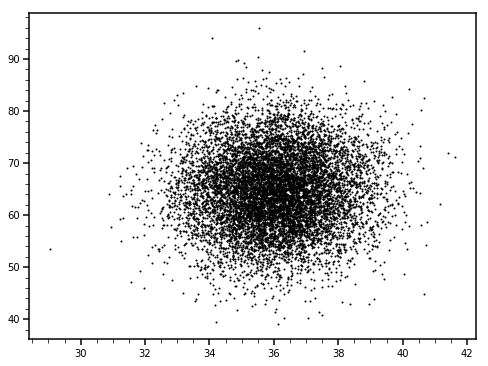

In [22]:
#plt.scatter(gal_latlon.pm_l_cosb,gal_latlon.pm_b,color='black',s=1.)

dist,b,l,vlos,vtheta,vphi = rm.compute_spherical(np.array(gal_defined.x),np.array(gal_defined.y),np.array(gal_defined.z),\
                                                np.array(gal_defined.v_x),np.array(gal_defined.v_y),np.array(gal_defined.v_z))



#plt.scatter(gal_defined.x,gal_defined.v_x,color='black',s=1.)
#plt.scatter(gal_defined.y,gal_defined.v_y,color='red',s=1.)
#plt.scatter(gal_defined.z,gal_defined.v_z,color='blue',s=1.)

#plt.scatter(180.*l/np.pi,180.*b/np.pi,color='black',s=1.)
#plt.axis([0,360,-90,90])

plt.scatter(dist,vlos,color='black',s=1.)

print(np.percentile(vlos,20.),np.percentile(vlos,50.),np.percentile(vlos,80.))
print(np.percentile(vphi,20.),np.percentile(vphi,50.),np.percentile(vphi,80.))




### Really need to flag GCs. You have the list, just do it already!

In [36]:
bhbcat = {}
bhbcat['ra'] = X11['RA'][keep]
bhbcat['dec'] = X11['Dec'][keep]
bhbcat['d'] = X11['d'][keep]
bhbcat['pmra'] = gaiadict['gpmra'][keep]#*np.cos(X11['Dec'][keep]* np.pi / 180.)
bhbcat['pmdec'] = gaiadict['gpmdec'][keep]
bhbcat['vrad'] = gaiadict['selodiervfinal'][keep]
bhbcat['feh'] = gaiadict['sfehspec'][keep]


In [37]:
BHB = newcoordinates(bhbcat)

BHB.gc_transform()
BHB.sph_transform()

In [38]:
BHB.x

<Quantity [  6.48672475,  -2.14758993,  -2.06893261, ...,  -3.55010681,
            -2.59577804, -21.26056491] kpc>

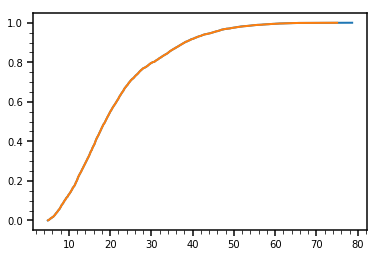

In [38]:
# interpolate the distance function to select mock stars

distsort = np.argsort(radj)
plt.plot(radj[distsort],np.linspace(0.,1.,radj.size))

f=open('bhbgiantrange.txt','w')
for indx in range(radj.size): print(radj[distsort][indx],np.linspace(0.,1.,radj.size)[indx],file=f)
f.close()
    
    
# invert to interpolate
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

spl = UnivariateSpline(radj[distsort],np.linspace(0.,1.,radj.size),k=4,s=1)
spl = interp1d(radj[distsort],np.linspace(0.,1.,radj.size),'nearest')
tstdist = np.linspace(5.,75.,1000)
plt.plot(tstdist,spl(tstdist))



In [170]:
BHB['feh']

TypeError: 'newcoordinates' object is not subscriptable

In [130]:
X11['Dec']

array([6.29243, 6.42941, 7.10858, ..., 0.63088, 0.36596, 0.47167])

In [163]:
# test the definitions of vl and vb

#17 45 40.04 -29 00 28.1
testcat = {}
testcat['ra'] = np.array([15.*(17.+(45./60.)+40.04/3600.)])
testcat['dec'] = np.array([-(29.+(0.)+28.1/3600.)])
testcat['d'] = np.array([8.2])
testcat['pmra'] = np.array([-0.2])
testcat['pmdec'] = np.array([0.2])
testcat['vrad'] = np.array([0.1])

T = newcoordinates(testcat)

T.gc_transform()
T.sph_transform()

print(T.l,T.b,T.vl,T.vb)

# takeaways: positive pmra, when facing the galactic centre, means increasing vl
# takeaways: positive pmdec, when facing the galactic centre, means increasing vb

[-0.05574013] [-0d02m46.1846s] [0.06652945] mas / yr [0.27490695] mas / yr


In [147]:
np.nanmin(X11['Dec'])

-19.25249

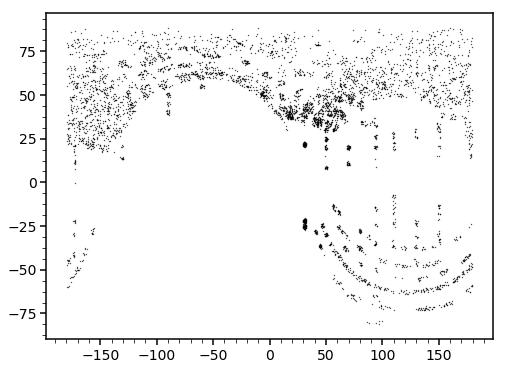

In [13]:
plt.scatter(BHB.l,BHB.b,color='black',s=0.1)

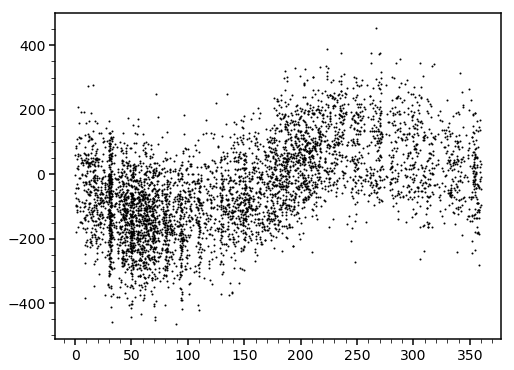

In [14]:
# try to transform back...

repv = coord.CartesianDifferential(d_x=BHB.vx,d_y=BHB.vy,d_z=BHB.vz)
rep = coord.CartesianRepresentation(x=BHB.x,y=BHB.y,z=BHB.z,\
                                    differentials=repv,unit='kpc')




#rep = coord.SkyCoord(x=BHB.x,y=BHB.y,z=BHB.z,unit='kpc',\
#                     representation_type='cartesian')


rept = coord.Galactocentric(rep)
repgal = rept.transform_to(coord.Galactic)

plt.scatter(repgal.l.degree,repgal.radial_velocity.value,color='black',s=1.)


#repgal = rept.transform_to(coord.Heliocentric)


#plt.scatter(repgal.l.degree,repgal.pm_l_cosb.value,color='black',s=1.)



In [15]:
Gmatch['ra']

array([331.04739862, 330.60694414, 330.92495452, ..., 191.67356168,
       191.2056253 , 147.16766211])

(0.0, 1.0)

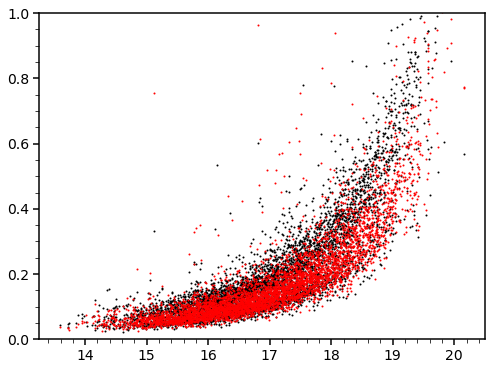

In [16]:
plt.scatter(Gmatch['phot_g_mean_mag'],Gmatch['pmra_error'],color='black',s=1.)
plt.scatter(Gmatch['phot_g_mean_mag'],Gmatch['pmdec_error'],color='red',s=1.)


#plt.axis([-1,1.,-1,1.])
plt.ylim([0.,1.])

In [27]:
# set the coordinates
usun = 11.1
vsun = 12.24
wsun = 7.25
vcirc = 235.
rsun = 8.3 # in kpc
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)

In [28]:
# set up coordinates and transform to the frame we want

c = coord.SkyCoord(ra=X11['RA'][keep]*u.deg,\
                   dec=X11['Dec'][keep]*u.deg,\
                   distance=X11['d'][keep]*u.kpc,\
                   pm_ra_cosdec=pmr[keep]*u.mas/u.yr,\
                   pm_dec=pmd[keep]*u.mas/u.yr,\
                   radial_velocity=radval[keep]*u.km/u.s)


#gc1 = c.transform_to(coord.Galactocentric) # this is default galactic
gc1 = c.transform_to(gc_frame) # for specific coordinates set above
#print(gc1.x,gc1.v_x, gc1.v_y, gc1.v_z)

In [29]:
def spherical_velocities(x,y,z,vx,vy,vz):
    """convert cartesian to spherical
    """
    rho = np.sqrt(x*x + y*y + z*z)
    r = np.sqrt(x*x + y*y)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    
    vr = (x*vx + y*vy + z*vz)/rho
    vtheta = (vx*y - x*vy)/(r*r)
    vphi = ( z*(x*vx + y*vy) - r*r*vz )/(rho*rho*r)
    
    return r,theta,phi,vr,vtheta,vphi

r,theta,phi,vr,vtheta,vphi = spherical_velocities(gc1.x,gc1.y,gc1.z,gc1.v_x,gc1.v_y,gc1.v_z)

In [30]:
# also need one for viewing velocities?
# we already have this measured...

# can astropy go backwards?



In [31]:
print(np.nanmedian(np.sqrt(gc1.x*gc1.x + gc1.y*gc1.y + gc1.z*gc1.z)))

18.82515496811176 kpc


In [32]:
(gaiag[keep]-14)/6.

array([0.86060783, 0.53378   , 0.55694333, ..., 0.54131133, 0.6434625 ,
       0.711141  ])

In [60]:

def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    dL=np.arctan(y0/x0)/f
    
    dL[(y0<0)&(x0>0.)] += 360.
    dL[(y0>0)&(x0<0.)] += 180.
    dL[(y0<0)&(x0<0.)] += 180.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub

In [61]:
dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(BHB.x),np.array(BHB.y),np.array(BHB.z),\
                               np.array(BHB.vx),np.array(BHB.vy),np.array(BHB.vz))

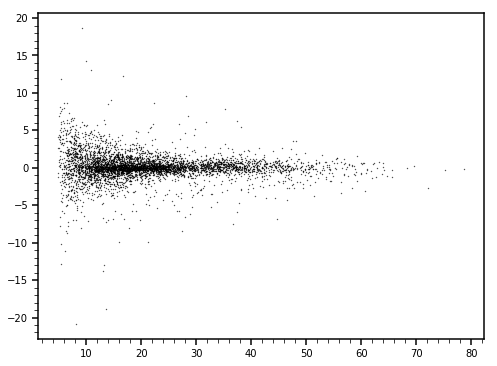

In [751]:
plt.scatter(radj,dmulj,color='black',s=0.1)

In [754]:
print(np.array(BHB.b)-dBj)

[ 1.99212852  2.17076603  2.03208416 ... -1.30181272 -2.33538575
  5.47616143]


## Appendix 1: Executed Queries

In [483]:

##Table1
#objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid

C = np.genfromtxt('/Users/mpetersen/Downloads/Skyserver_Radial4_4_2020 11_14_36 PM.csv',\
                 dtype={'names': ("objid","ra","dec",\
                                         "u","g","r","i","z",\
                                         "run","rerun","camcol","field",\
                                         "specobjid","class","redshift",\
                                         "plate","mjd","fiberid"),\
                             'formats': ('S20','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'S20','S20','f8',\
                                        'i4','i4','i4')},\
                 skip_header=2,delimiter=',')


In [608]:
# segue is 1660/3480

segue = np.where( (C['plate']>1660) & (C['plate']<3480))[0]
segue = np.where( (C['plate']>266) & (C['plate']<3006))[0]


print(segue.size)


10378


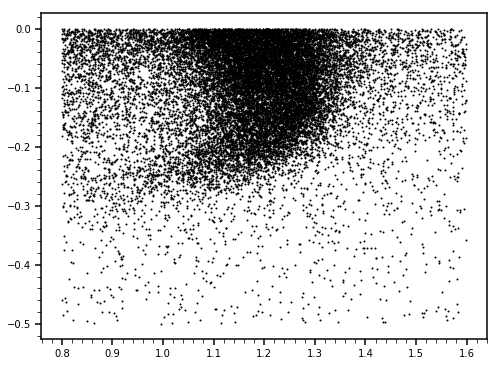

In [484]:
C['class'][C['class']==b'STAR'].size

gr = C['g']-C['r']
ug = C['u']-C['g']
w = np.where(C['class']==b'STAR')[0]
plt.scatter(ug[w],gr[w],color='black',s=1.)

In [610]:
def print_file_name(indx,file):
    #print(C['plate'][indx].decode()+'/spec-'+C['plate'][indx].decode()+\
    #                               '-'+C['mjd'][indx].decode()+\
    #                               '-'+C['fiberid'][indx].decode()+'.fits')

    print('{0:04d}/spec-{1:04d}-{2}-{3:04d}.fits'.format(C['plate'][indx],\
                                                 C['plate'][indx],\
                                                 C['mjd'][indx],\
                                                 C['fiberid'][indx]),file=file)


f = open('/Users/mpetersen/Downloads/SEGUE/fullspec.txt','w')
for i in range(0,segue.size):
    print_file_name(segue[i],file=f)
    
f.close()

#/usr/local/Cellar/wget/1.20.3_2/bin/wget -i fullspec.txt -B http://data.sdss3.org/sas/dr9/sdss/spectro/redux/26/spectra/



failed for /Users/mpetersen/Downloads/SEGUE/spec-0701-52179-0443.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0755-52235-0259.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0772-52375-0091.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0802-52289-0423.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0803-52318-0598.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0827-52312-0523.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0852-52375-0017.fits
failed for /Users/mpetersen/Downloads/SEGUE/spec-0885-52379-0494.fits


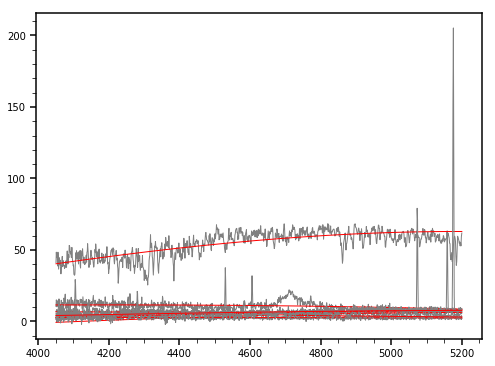

In [652]:
# prototyper for when things are stuck:


for indx,infile in enumerate(F[400:500]):
    
    hdul = fits.open(infile)

    data = np.array(hdul[1].data)

    wave = 10.**(data['loglam'])
    flux = data['flux']
    outwave,outflux = normalise_continuum(wave,flux)
    
    #

    try:
        fms[indx],D02s[indx],bs[indx],cs[indx] = fit_hgamma(outwave,outflux)
    except:
        print('failed for {}'.format(infile))
        outwave,outflux,fitflux = normalise_continuum(wave,flux,diagnostic=True)
        plt.plot(outwave,outflux,color='gray',lw=1.)
        plt.plot(outwave,fitflux,color='red',lw=1.)





In [702]:
import glob

F = glob.glob('/Users/mpetersen/Downloads/SEGUE/*.fits')


HG = {}
HG['fms'] = np.zeros(len(F))
HG['D02s'] = np.zeros(len(F))
HG['cs'] = np.zeros(len(F))
HG['bs'] = np.zeros(len(F))
HG['x0s'] = np.zeros(len(F))
HG['efms'] = np.zeros(len(F))
HG['eD02s'] = np.zeros(len(F))
HG['ecs'] = np.zeros(len(F))
HG['ebs'] = np.zeros(len(F))
HG['ex0s'] = np.zeros(len(F))

HD = {}
HD['fms'] = np.zeros(len(F))
HD['D02s'] = np.zeros(len(F))
HD['cs'] = np.zeros(len(F))
HD['bs'] = np.zeros(len(F))
HD['x0s'] = np.zeros(len(F))

import warnings
warnings.simplefilter('ignore', np.RankWarning)

f = open('/Users/mpetersen/Downloads/SEGUE/allrejected.txt','w')

for indx,infile in enumerate(F):
    
    hdul = fits.open(infile)

    data = np.array(hdul[1].data)

    wave = 10.**(data['loglam'])
    flux = data['flux']
    outwave,outflux = normalise_continuum(wave,flux)
    
    #plt.plot(outwave,outflux)

    badflag = 0
    try:
        #fms[indx],D02s[indx],bs[indx],cs[indx] = fit_hdelta(outwave,outflux)

        
        HG['fms'][indx],HG['D02s'][indx],HG['bs'][indx],HG['cs'][indx],HG['x0s'][indx],\
        HG['efms'][indx],HG['eD02s'][indx],HG['ebs'][indx],HG['ecs'][indx],HG['ex0s'][indx] = fit_hgamma(outwave,outflux)
    except:
        
        # from testing above, it's fairly clear that the failures result from non-stellar sources.
        # so what are they?? might need to look into that
        badflag += 1
        
    try:
        HD['fms'][indx],HD['D02s'][indx],HD['bs'][indx],HD['cs'][indx],HD['x0s'][indx] = fit_hdelta(outwave,outflux)

    except:
        badflag += 1
    
    if badflag==2:
        # print obviously bad files so that we can eliminate them for space considerations

        print(infile,file=f)


f.close()

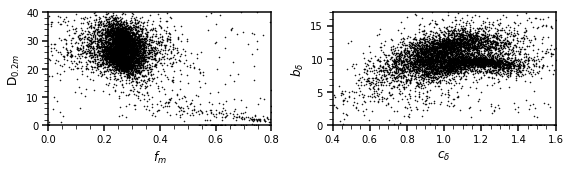

In [700]:

# h delta plot
fig = plt.figure(figsize=(8,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(HD['fms'],HD['D02s'],color='black',s=0.3)
ax1.axis([0.,0.8,0.,40.])
ax1.set_xlabel('$f_m$',size=12)
ax1.set_ylabel('D$_{0.2m}$',size=12)

ax2.scatter(HD['cs'],HD['bs'],color='black',s=0.3)
ax2.axis([0.4,1.6,0.,17.])
ax2.set_xlabel('$c_\delta$',size=12)
ax2.set_ylabel('$b_\delta$',size=12)

fig.tight_layout()

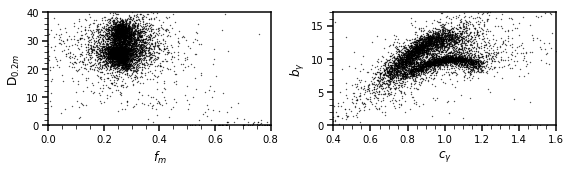

In [699]:

# h gamma plot
fig = plt.figure(figsize=(8,2.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(HG['fms'],HG['D02s'],color='black',s=0.1)
ax1.axis([0.,0.8,0.,40.])
ax1.set_xlabel('$f_m$',size=12)
ax1.set_ylabel('D$_{0.2m}$',size=12)

ax2.scatter(HG['cs'],HG['bs'],color='black',s=0.1)
ax2.axis([0.4,1.6,0.,17.])
ax2.set_xlabel('$c_\gamma$',size=12)
ax2.set_ylabel('$b_\gamma$',size=12)

fig.tight_layout()

[-600, 600, -600, 600]

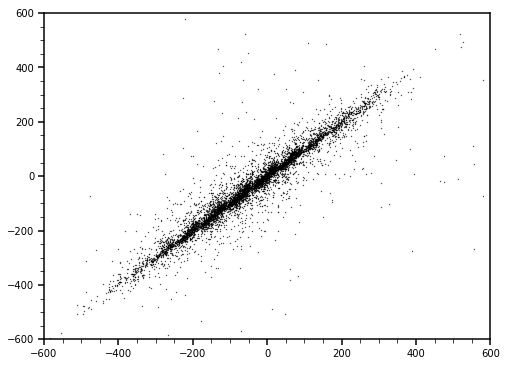

In [701]:
velocitiesHG = speed_of_light*(HG['x0s']-balmer['gamma'])/balmer['gamma']
velocitiesHD = speed_of_light*(HD['x0s']-balmer['delta'])/balmer['delta']


plt.scatter(velocitiesHG,velocitiesHD,color='black',s=0.1)
plt.axis([-600,600,-600,600])


(-600.0, 600.0)

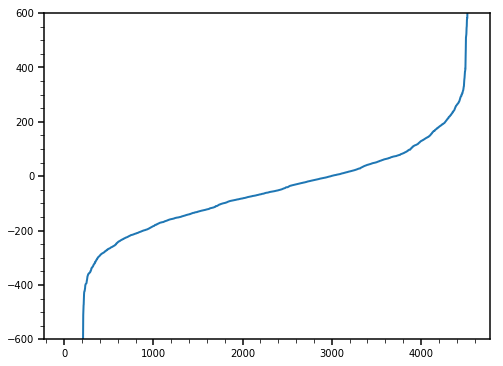

In [688]:
plt.plot(velocities[velocities.argsort()])
plt.ylim(-600.,600.)

In [500]:

hdul.info()

Filename: /Users/mpetersen/Downloads/SEGUE/spec-2047-53732-0552.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  COADD         1 BinTableHDU     26   3831R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   
  4  B2-00035942-00035940-00035941    1 BinTableHDU    146   2047R x 7C   [E, E, E, J, E, E, E]   
  5  B2-00035943-00035940

In [593]:
print(data['ivar'])
print(data['flux'])

[0.02843923 0.03051122 0.03058311 ... 0.45608446 0.43514284 0.41500518]
[100.01546   99.661964  98.72565  ...  18.909353  18.134226  14.046533]


In [675]:
balmer = {}
balmer['alpha'] = 6563.
balmer['beta'] = 4861.
balmer['gamma'] = 4341.692
balmer['delta'] = 4102.892


In [648]:
data.shape
#plt.plot(,data['flux'])
#plt.xlim(3000.,5000.)



def normalise_continuum(wave,flux,diagnostic=False):
    ww = np.where( ((wave>4200) & (wave<4300)) |\
                  ((wave>4400) & (wave<4800)) |\
                  ((wave>4950) & (wave<5500)))
    
    w = np.where((wave>4050) & (wave<5200))
    p = np.polyfit(wave[ww],flux[ww],4)
    pfunc = np.poly1d(p)

    if diagnostic:
        return wave[w],flux[w],pfunc(wave[w])
        
    else:
        return wave[w],flux[w]/pfunc(wave[w])


infile = '/Users/mpetersen/Downloads/SEGUE/spec-2047-53732-0552.fits'
hdul = fits.open(infile)
data = np.array(hdul[1].data)


wave = 10.**(data['loglam'])
flux = data['flux']
outwave,outflux = normalise_continuum(wave,flux)

fm,D02,b,c = fit_hgamma(outwave,outflux)



#plt.plot(wave[w],flux[w],color='black')
#plt.plot(wave[w],pfunc(wave[w]),color='red')
#plt.plot(outwave,outflux,color='red')
#plt.plot([np.nanmin(wave[w]),np.nanmax(wave[w])],[1.,1.],color='gray',linestyle='dashed')

In [590]:
def sersic(x,a,b,c,x0,level=1.):
    
    return level - a*np.exp(- (np.abs(x-x0)/b)**c)
    

In [695]:

from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.optimize import brentq




def fit_hdelta(wave,flux):
    
    hdelta = np.where( (wave>4050) & (wave<4200))

    popt, pcov = curve_fit(sersic, wave[hdelta],flux[hdelta],p0=(0.8,10.,1.,4102.))

    fm = 1.-popt[0]
    b = popt[1]
    c = popt[2]
    x0 = popt[3]
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))

    D02 = hiroot - loroot
    
    return fm,D02,b,c,x0




def fit_hgamma(wave,flux,error=True):
    
    hgamma = np.where( (wave>4250) & (wave<4450))

    popt, pcov = curve_fit(sersic, wave[hgamma],flux[hgamma],p0=(0.8,10.,1.,4350.))

    
    fm = 1.-popt[0]
    b = popt[1]
    c = popt[2]
    x0 = popt[3]

    perr = np.sqrt(np.diag(pcov))
    efm = perr[0]
    eb = perr[1]
    ec = perr[2]
    ex0 = perr[3]
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0],popt[1],popt[2],popt[3],0.2))

    D02 = hiroot - loroot
    
    loroot = brentq(sersic,0,popt[3],args=(popt[0]-perr[0],popt[1]-perr[1],popt[2]-perr[2],popt[3]-perr[3],0.2))
    hiroot = brentq(sersic,popt[3],2.*popt[3],args=(popt[0]-perr[0],popt[1]-perr[1],popt[2]-perr[2],popt[3]-perr[3],0.2))

    # need to figure out if this is a good error estimate...
    eD02 = hiroot - loroot

    if error:
        return fm,D02,b,c,x0,efm,eD02,eb,ec,ex0
    
    else:
        return fm,D02,b,c,x0


#plt.plot(wave[hgamma],flux[hgamma]/pfunc(wave[hgamma]),color='black')
#plt.plot([np.nanmin(wave[hgamma]),np.nanmax(wave[hgamma])],[1.,1.],color='gray',linestyle='dashed')


speed_of_light = 3.e5 # in km/s

fm,D02,b,c,x0,efm,eD02,eb,ec,ex0 = fit_hgamma(outwave,outflux)
print('fm={0:3.3f}'.format(fm))
print('D02={0:3.2f}'.format(D02))
print(speed_of_light*(x0-balmer['gamma'])/balmer['gamma'])

fm,D02,b,c,x0 = fit_hdelta(outwave,outflux)
print('fm={0:3.3f}'.format(fm))
print('D02={0:3.2f}'.format(D02))
print(speed_of_light*(x0-balmer['delta'])/balmer['delta'])




fm=0.210
D02=24.08
-40.79962418201576
fm=0.211
D02=20.72
8.219117459834155


In [696]:
print(efm)

0.07560577312284351


Note that I seem to have lost the technology to upload tables with source_id for matching. ra/dec seems possible?